In [1]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 5.4 MB/s 


# Packageks Using

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import missingno as msno
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import keras_tuner as kt

In [3]:
print(tf.__version__)

2.8.0


In [4]:
colors_blue = ["#132C33", "#264D58", '#17869E', '#51C4D3', '#B4DBE9']
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_mix = ["#17869E", '#264D58', '#179E66', '#D35151', '#E9DAB4', '#E9B4B4', '#D3B651', '#6351D3']
colors_div = ["#132C33", '#17869E', '#DADADA', '#D35151', '#331313']

In [5]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
df = pd.read_excel('/content/drive/MyDrive/skripsi ghanes/dataset-fix.xlsx', sheet_name='fix')
df.head()

,Kebijakan,Periode (hari),Revenue,Tanggal
0,PSBB,10.0,1.561507e+11,2020-04-10
1,PSBB,2.0,6.774117e+11,2020-04-12
2,PSBB,8.0,1.472724e+11,2020-04-20
3,PSBB,5.0,1.832997e+11,2020-04-25
4,PSBB,5.0,8.791090e+11,2020-04-30


In [7]:
revenue_scaler = StandardScaler()

revenue_scaled = revenue_scaler.fit_transform(df['Revenue'].values.reshape(-1,1))
df['Revenue Scaled'] = revenue_scaled
df.head()

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled
0,PSBB,10.0,1.561507e+11,2020-04-10,-0.334089
1,PSBB,2.0,6.774117e+11,2020-04-12,1.572951
2,PSBB,8.0,1.472724e+11,2020-04-20,-0.366570
3,PSBB,5.0,1.832997e+11,2020-04-25,-0.234764
4,PSBB,5.0,8.791090e+11,2020-04-30,2.310863


In [8]:
df['Kebijakan'].unique()

array(['PSBB', 'PSBB  TRANSISI', 'PSBB KETAT', 'PSBB  TRANSISI FASE 2',
       'PPKM', 'PPKM  MIKRO', 'PPKM DARURAT', 'PPKM LEVEL 3 & 4',
       'PPKM LEVEL 2, 3, & 4', 'PPKM  LEVEL 1, 2, & 3'], dtype=object)

# Helper Function

## MSE & MAE

In [9]:
def mae(y_test, y_pred):
  """
  Calculuates mean absolute error between y_test and y_preds.
  """
  return tf.metrics.mean_absolute_error(y_test.squeeze(),
                                        y_pred.squeeze()).numpy()
  
def mse(y_test, y_pred):
  """
  Calculates mean squared error between y_test and y_preds.
  """
  return tf.metrics.mean_squared_error(y_test.squeeze(),
                                       y_pred.squeeze()).numpy()

## Visualization

In [10]:
def plot_predictions(date_df ,real_data, predictions, title, subtitle):
  """
  Plots real data vs prediction.
  """
  df = date_df
  df['Revenue'] = real_data
  df['Revenue Prediction'] = predictions

  fig, ax = plt.subplots(figsize=(14, 8), dpi=75)
  line_real_data = ax.plot(df['Tanggal'], df['Revenue'], alpha=1, marker='o', color=colors_blue[3], linewidth=3, label='Real Data')
  line_prediction_data = ax.plot(df['Tanggal'], df['Revenue Prediction'], alpha=1, marker='x', color=colors_red[3], linewidth=3, label='Predictions')
  
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, borderpad=1, frameon=False, fontsize=12)
  ax.grid(axis='y', alpha=0.3)
  ax.set_axisbelow(True)
  # ax.set_xlabel("Countries", fontsize=14, labelpad=10, fontweight='bold', color=colors_dark[0])
  ax.set_ylabel("Revenue", fontsize=14, labelpad=10, fontweight='bold', color=colors_dark[0])

  xmin, xmax = ax.get_xlim()
  ymin, ymax = ax.get_ylim()
  plt.text(s=title, ha='left', x=xmin, y=ymax*1.1, fontsize=24, fontweight='bold', color=colors_dark[0])
  plt.title(subtitle, loc='left', fontsize=13, color=colors_dark[2])  
  plt.tight_layout()
  plt.show()

# Hyperparameter Tuning (Date Feature)

In [11]:
df['hari'] = df['Tanggal'].dt.day_of_week
df['bulan'] = df['Tanggal'].dt.month
df['tahun'] = df['Tanggal'].dt.year

df.head()

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun
0,PSBB,10.0,1.561507e+11,2020-04-10,-0.334089,4,4,2020
1,PSBB,2.0,6.774117e+11,2020-04-12,1.572951,6,4,2020
2,PSBB,8.0,1.472724e+11,2020-04-20,-0.366570,0,4,2020
3,PSBB,5.0,1.832997e+11,2020-04-25,-0.234764,5,4,2020
4,PSBB,5.0,8.791090e+11,2020-04-30,2.310863,3,4,2020


In [12]:
features_date_day_scaler = MinMaxScaler()
features_date_month_scaler = MinMaxScaler()
features_date_year_scaler = MinMaxScaler()


day_scaled = features_date_day_scaler.fit_transform(df['hari'].values.reshape(-1,1))
df['Day Scaled'] = day_scaled

month_scaled = features_date_month_scaler.fit_transform(df['bulan'].values.reshape(-1,1))
df['Month Scaled'] = month_scaled

year_scaled = features_date_year_scaler.fit_transform(df['tahun'].values.reshape(-1,1))
df['Year Scaled'] = year_scaled


df.head()

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
0,PSBB,10.0,1.561507e+11,2020-04-10,-0.334089,4,4,2020,0.666667,0.272727,0.0
1,PSBB,2.0,6.774117e+11,2020-04-12,1.572951,6,4,2020,1.000000,0.272727,0.0
2,PSBB,8.0,1.472724e+11,2020-04-20,-0.366570,0,4,2020,0.000000,0.272727,0.0
3,PSBB,5.0,1.832997e+11,2020-04-25,-0.234764,5,4,2020,0.833333,0.272727,0.0
4,PSBB,5.0,8.791090e+11,2020-04-30,2.310863,3,4,2020,0.500000,0.272727,0.0


In [13]:
features_scaled = df[['Day Scaled', 'Month Scaled', 'Year Scaled']]
label = df['Revenue Scaled']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, label, test_size=0.33, random_state=42)

In [15]:
def build_model(hp):
  model = tf.keras.Sequential()
  for i in range(hp.Int('num_layers', 2,6)):
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units_' + str(i), 16, 512, step=16),
        activation=hp.Choice('act_' + str(i), ['relu', 'tanh'])
    ))
    if hp.Boolean("dropout"):
        model.add(tf.keras.layers.Dropout(rate=0.25))
  model.add(tf.keras.layers.Dense(1, activation='linear'))

  hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse')
  return model

In [16]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=5,
    directory="kt_dir",
    project_name="kt_hyperband"
)

In [17]:
tuner.search(X_train, y_train,
             epochs=100,
             validation_data=(X_test,y_test))

Trial 20 Complete [00h 00m 38s]
val_loss: 0.9761492252349854

Best val_loss So Far: 0.9521261930465699
Total elapsed time: 00h 12m 56s
INFO:tensorflow:Oracle triggered exit


In [18]:
tuner.search_space_summary()

Search space summary
Default search space size: 15
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}
act_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}
act_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}
act_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_3 (Int)
{'default': Non

In [19]:
tuner.results_summary()

Results summary
Results in kt_dir/kt_hyperband
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 5
units_0: 336
act_0: tanh
dropout: False
units_1: 272
act_1: relu
learning_rate: 0.01
units_2: 48
act_2: tanh
units_3: 128
act_3: tanh
units_4: 336
act_4: tanh
units_5: 96
act_5: tanh
Score: 0.9521261930465699
Trial summary
Hyperparameters:
num_layers: 5
units_0: 288
act_0: tanh
dropout: False
units_1: 464
act_1: tanh
learning_rate: 0.001
units_2: 432
act_2: tanh
units_3: 288
act_3: relu
units_4: 320
act_4: tanh
units_5: 128
act_5: relu
Score: 0.9537392616271972
Trial summary
Hyperparameters:
num_layers: 4
units_0: 416
act_0: tanh
dropout: False
units_1: 192
act_1: relu
learning_rate: 0.01
units_2: 208
act_2: tanh
units_3: 80
act_3: tanh
units_4: 32
act_4: tanh
units_5: 368
act_5: tanh
Score: 0.9607106208801269
Trial summary
Hyperparameters:
num_layers: 4
units_0: 288
act_0: tanh
dropout: True
units_1: 416
act_1: tanh
learning_rate: 0.01
units_2: 96
act_2: tanh
units_3: 112

## Model Tuning

In [20]:
tf.random.set_seed(42)


# Build the model 
model_tuning = tf.keras.Sequential([
  tf.keras.layers.Dense(224, activation='tanh'),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(480, activation='relu'),
  tf.keras.layers.Dense(272, activation='relu'),
  tf.keras.layers.Dense(208, activation='relu'),
  tf.keras.layers.Dense(112, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear') 
])

# Compile the model
model_tuning.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_model_tuning = model_tuning.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0, validation_split=0.25, shuffle=False) 

In [21]:
model_tuning.evaluate(X_test, y_test)

2/2 [==============================] - 0s 5ms/step - loss: 1.2485 - mse: 1.2485 - mae: 0.8309


[1.24850332736969, 1.24850332736969, 0.8308895826339722]

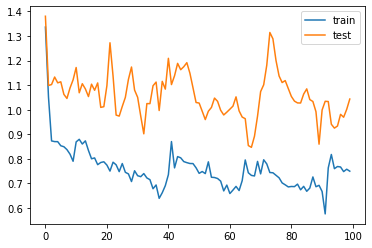

In [22]:
plt.plot(history_model_tuning.history['loss'], label='train')
plt.plot(history_model_tuning.history['val_loss'], label='test')
plt.legend();

## Model Tuning Evaluation

In [23]:
model_tuning_pred = model_tuning.predict(X_test)
model_tuning_pred

array([[-0.307779  ],
       [-0.15528801],
       [-0.06885735],
       [-0.33644202],
       [-0.22082123],
       [-0.29441777],
       [ 0.20545942],
       [-0.1057213 ],
       [-0.310832  ],
       [-0.18205908],
       [-0.20835537],
       [-0.18954444],
       [-0.09740942],
       [-0.28437075],
       [ 0.3292629 ],
       [-0.39297038],
       [-0.17733562],
       [-0.14325604],
       [-0.14894822],
       [-0.2250888 ],
       [-0.11173054],
       [-0.26547995],
       [-0.29441777],
       [-0.16917825],
       [ 0.7533517 ],
       [ 0.12537514],
       [-0.29003006],
       [-0.2998233 ],
       [-0.19674554],
       [-0.1623762 ],
       [-0.31083205],
       [-0.22075379],
       [-0.05625103],
       [-0.16309318],
       [-0.22082123],
       [ 0.9613664 ]], dtype=float32)

In [24]:
model_tuning_revenue = y_test.to_numpy()
model_tuning_revenue

array([-0.7670767 ,  1.42096156,  2.3108625 , -0.78618562, -0.29334398,
        1.1863331 , -0.61265103, -0.71389304, -0.77860535, -0.22578601,
       -0.42311354, -0.32853202, -0.33408906,  1.81351442,  2.62756614,
       -0.78519053,  0.73646218, -0.75352881, -0.64517891,  1.81182541,
       -0.18345437, -0.73658654, -0.43312055,  0.48296249, -0.64354933,
       -0.21949649, -0.40222175, -0.810466  , -0.40905037,  1.29312264,
       -0.79552564, -0.77960087,  0.62943115, -0.63668505,  2.59774929,
       -0.7710738 ])

In [25]:
model_tuning_pred_inv = revenue_scaler.inverse_transform(model_tuning_pred)
model_tuning_revenue_inv = revenue_scaler.inverse_transform(model_tuning_revenue.reshape(-1,1))
model_tuning_pred_inv.shape, model_tuning_revenue_inv.shape 

((36, 1), (36, 1))

In [26]:
MSE_mt_Standard = mse(model_tuning_revenue_inv, model_tuning_pred_inv)
MAE_mt_Standard = mae(model_tuning_revenue_inv, model_tuning_pred_inv)
r2_mt = r2_score(model_tuning_revenue_inv, model_tuning_pred_inv)
mape_mt = mean_absolute_percentage_error(model_tuning_revenue_inv, model_tuning_pred_inv)

print(f'Mean Squared Error : {MSE_mt_Standard}')
print(f'Mean Absolute Error : {MAE_mt_Standard}')
print(f'Coefficient of Determination : {r2_mt}')
print(f'Mean Absolute Percentage Error : {mape_mt}')

Mean Squared Error : 9.327833030211634e+22
Mean Absolute Error : 227111354368.0
Coefficient of Determination : -0.09820001215263163
Mean Absolute Percentage Error : 2.0288720199082744


## Model Tuning Visualization

In [27]:
model_tuning_revenue_inv = model_tuning_revenue_inv.squeeze()
model_tuning_pred_inv = model_tuning_pred_inv.squeeze()
df_tuning = pd.Series(model_tuning_revenue_inv)
df_tuning = df_tuning.rename('revenue')
df_tuning = df_tuning.to_frame()
df_tuning['revenue prediction'] = model_tuning_pred_inv
df_tuning = df_tuning.reset_index()
df_tuning.head()

,index,revenue,revenue prediction
0,0,3.779995e+10,1.633422e+11
1,1,6.358678e+11,2.050233e+11
2,2,8.791090e+11,2.286478e+11
3,3,3.257680e+10,1.555076e+11
4,4,1.672878e+11,1.871108e+11


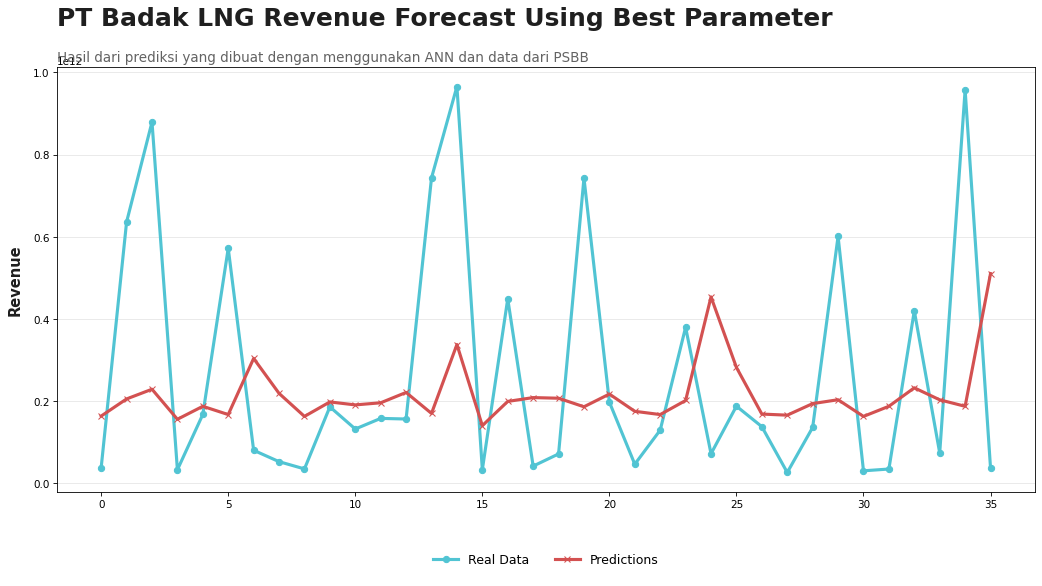

In [28]:
title_tuning = 'PT Badak LNG Revenue Forecast Using Best Parameter'
subtitle_tuning = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PSBB'
fig, ax = plt.subplots(figsize=(14, 8), dpi=75)
line_real_data = ax.plot(df_tuning['index'], df_tuning['revenue'], alpha=1, marker='o', color=colors_blue[3], linewidth=3, label='Real Data')
line_prediction_data = ax.plot(df_tuning['index'], df_tuning['revenue prediction'], alpha=1, marker='x', color=colors_red[3], linewidth=3, label='Predictions')
  
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, borderpad=1, frameon=False, fontsize=12)
ax.grid(axis='y', alpha=0.3)
ax.set_axisbelow(True)
  # ax.set_xlabel("Countries", fontsize=14, labelpad=10, fontweight='bold', color=colors_dark[0])
ax.set_ylabel("Revenue", fontsize=14, labelpad=10, fontweight='bold', color=colors_dark[0])

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
plt.text(s=title_tuning, ha='left', x=xmin, y=ymax*1.1, fontsize=24, fontweight='bold', color=colors_dark[0])
plt.title(subtitle_tuning, loc='left', fontsize=13, color=colors_dark[2])  
plt.tight_layout()
plt.show()

# Model with Date as Feature

## PSBB

In [29]:
df_psbb_2 = df[df['Kebijakan'] == 'PSBB']
df_psbb_2

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
0,PSBB,10.0,1.561507e+11,2020-04-10,-0.334089,4,4,2020,0.666667,0.272727,0.0
1,PSBB,2.0,6.774117e+11,2020-04-12,1.572951,6,4,2020,1.000000,0.272727,0.0
2,PSBB,8.0,1.472724e+11,2020-04-20,-0.366570,0,4,2020,0.000000,0.272727,0.0
3,PSBB,5.0,1.832997e+11,2020-04-25,-0.234764,5,4,2020,0.833333,0.272727,0.0
4,PSBB,5.0,8.791090e+11,2020-04-30,2.310863,3,4,2020,0.500000,0.272727,0.0
5,PSBB,10.0,1.474547e+11,2020-05-10,-0.365904,6,5,2020,1.000000,0.363636,0.0
6,PSBB,8.0,1.760403e+11,2020-05-18,-0.261323,0,5,2020,0.000000,0.363636,0.0
7,PSBB,7.0,1.758892e+11,2020-05-25,-0.261876,0,5,2020,0.000000,0.363636,0.0
8,PSBB,7.0,1.432047e+11,2020-06-01,-0.381452,0,6,2020,0.000000,0.454545,0.0
9,PSBB,2.0,4.195147e+11,2020-06-03,0.629431,2,6,2020,0.333333,0.454545,0.0


In [30]:
column_date_features = ['Day Scaled', 'Month Scaled', 'Year Scaled']

In [31]:
feature_psbb_2 = df_psbb_2[column_date_features]
revenue_psbb_2 = df_psbb_2['Revenue Scaled']

feature_psbb_2.shape, revenue_psbb_2.shape

((10, 3), (10,))

### Model

In [32]:
tf.random.set_seed(42)


# Build the model 
model_psbb_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(224, activation='tanh'),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(480, activation='relu'),
  tf.keras.layers.Dense(272, activation='relu'),
  tf.keras.layers.Dense(208, activation='relu'),
  tf.keras.layers.Dense(112, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear') 
])

# Compile the model
model_psbb_2.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_model_psbb_2 = model_psbb_2.fit(feature_psbb_2, revenue_psbb_2, batch_size=32, epochs=100, verbose=0, validation_split=0.25, shuffle=False) 

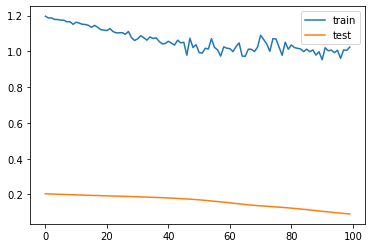

In [33]:
plt.plot(history_model_psbb_2.history['loss'], label='train')
plt.plot(history_model_psbb_2.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [34]:
revenUe_psbb_pred_2 = model_psbb_2.predict(feature_psbb_2)
revenUe_psbb_pred_2

array([[ 0.4342457 ],
       [ 0.571462  ],
       [-0.07742471],
       [ 0.5034293 ],
       [ 0.36279657],
       [ 0.5821761 ],
       [-0.09410851],
       [-0.09410851],
       [-0.10960347],
       [ 0.2152455 ]], dtype=float32)

In [35]:
revenue_psbb_2 = revenue_psbb_2.to_numpy()
revenue_psbb_2

array([-0.33408906,  1.5729506 , -0.36657031, -0.23476395,  2.3108625 ,
       -0.36590357, -0.26132273, -0.26187564, -0.38145209,  0.62943115])

In [36]:
revenue_psbb_2_inv = revenue_scaler.inverse_transform(revenue_psbb_2.reshape(-1,1))
revenue_psbb_2_pred_inv = revenue_scaler.inverse_transform(revenUe_psbb_pred_2)
revenue_psbb_2_inv.shape, revenue_psbb_2_pred_inv.shape 

((10, 1), (10, 1))

In [37]:
MSE_psbb_2_Standard = mse(revenue_psbb_2_inv, revenue_psbb_2_pred_inv)
MAE_psbb_2_Standard = mae(revenue_psbb_2_inv, revenue_psbb_2_pred_inv)
r2_psbb_2 = r2_score(revenue_psbb_2_inv, revenue_psbb_2_pred_inv)
mape_psbb_2 = mean_absolute_percentage_error(revenue_psbb_2_inv, revenue_psbb_2_pred_inv)

print(f'Mean Squared Error : {MSE_psbb_2_Standard}')
print(f'Mean Absolute Error : {MAE_psbb_2_Standard}')
print(f'Coefficient of Determination : {r2_psbb_2}')
print(f'Mean Absolute Percentage Error : {mape_psbb_2}')


Mean Squared Error : 5.392142269812148e+22
Mean Absolute Error : 183526064128.0
Coefficient of Determination : 0.14034155613047972
Mean Absolute Percentage Error : 0.7058704396227127


### Visualization

In [38]:
revenue_psbb_2_inv = revenue_psbb_2_inv.squeeze()
revenue_psbb_2_pred_inv = revenue_psbb_2_pred_inv.squeeze()
date_psbb_2 = df_psbb_2['Tanggal']
date_psbb_2 = date_psbb_2.to_frame()

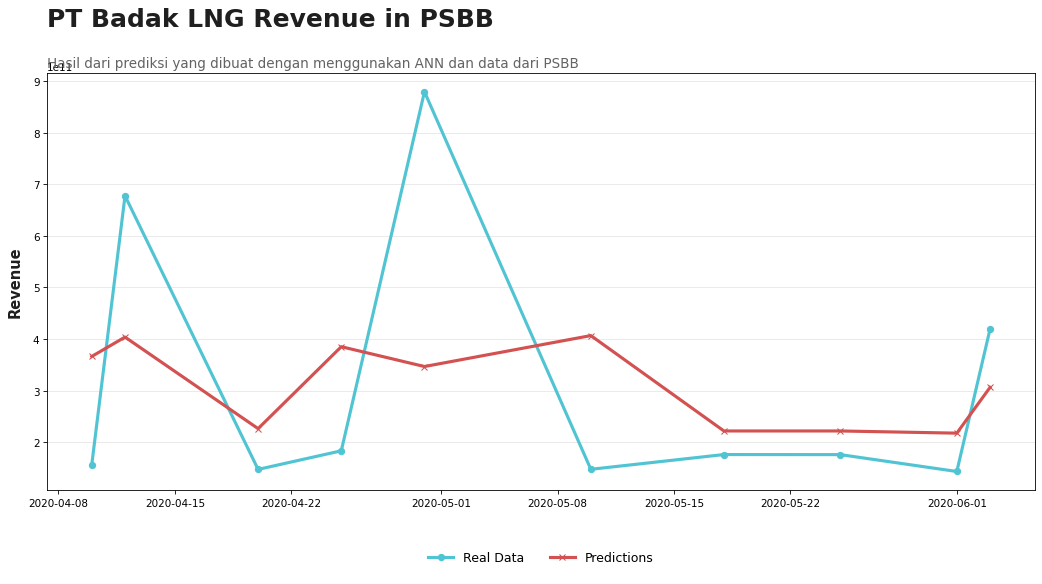

In [39]:
title_ann_standard = 'PT Badak LNG Revenue in PSBB'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PSBB'
plot_predictions(date_psbb_2,revenue_psbb_2_inv, revenue_psbb_2_pred_inv, title_ann_standard, subtitle_ann_standard)

## PSBB TANSISI

In [40]:
df_psbb_trans_2 = df[df['Kebijakan'] == 'PSBB  TRANSISI']
df_psbb_trans_2

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
10,PSBB TRANSISI,10.0,6.358678e+11,2020-06-13,1.420962,5,6,2020,0.833333,0.454545,0.0
11,PSBB TRANSISI,8.0,1.857537e+11,2020-06-21,-0.225786,6,6,2020,1.000000,0.454545,0.0
12,PSBB TRANSISI,11.0,1.973245e+11,2020-07-02,-0.183454,3,7,2020,0.500000,0.545455,0.0
13,PSBB TRANSISI,5.0,9.416419e+11,2020-07-07,2.539640,1,7,2020,0.166667,0.545455,0.0
14,PSBB TRANSISI,8.0,1.087409e+12,2020-07-15,3.072929,2,7,2020,0.333333,0.545455,0.0
15,PSBB TRANSISI,11.0,1.356611e+11,2020-07-26,-0.409050,6,7,2020,1.000000,0.545455,0.0
16,PSBB TRANSISI,13.0,1.476348e+11,2020-08-08,-0.365245,5,8,2020,0.833333,0.636364,0.0
17,PSBB TRANSISI,9.0,5.442950e+11,2020-08-17,1.085942,0,8,2020,0.000000,0.636364,0.0
18,PSBB TRANSISI,2.0,9.656752e+11,2020-08-19,2.627566,2,8,2020,0.333333,0.636364,0.0
19,PSBB TRANSISI,15.0,8.314508e+10,2020-09-03,-0.601181,3,9,2020,0.500000,0.727273,0.0


In [41]:
feature_psbb_trans_2 = df_psbb_trans_2[column_date_features]
revenue_psbb_trans_2 = df_psbb_trans_2['Revenue Scaled']

feature_psbb_trans_2.shape, revenue_psbb_trans_2.shape

((10, 3), (10,))

### Model

In [42]:
tf.random.set_seed(42)


# Build the model 
model_psbb_trans_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(224, activation='tanh'),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(480, activation='relu'),
  tf.keras.layers.Dense(272, activation='relu'),
  tf.keras.layers.Dense(208, activation='relu'),
  tf.keras.layers.Dense(112, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear') 
])

# Compile the model
model_psbb_trans_2.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_model_psbb_trans_2 = model_psbb_trans_2.fit(feature_psbb_trans_2, revenue_psbb_trans_2, batch_size=32, epochs=100, verbose=0, validation_split=0.25, shuffle=False) 

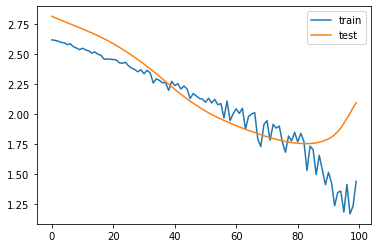

In [43]:
plt.plot(history_model_psbb_trans_2.history['loss'], label='train')
plt.plot(history_model_psbb_trans_2.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [44]:
revenUe_psbb_trans_pred_2 = model_psbb_trans_2.predict(feature_psbb_trans_2)
revenUe_psbb_trans_pred_2

array([[0.16271071],
       [0.05297543],
       [1.0257194 ],
       [1.6449564 ],
       [1.3909411 ],
       [0.12248448],
       [0.52143747],
       [1.9802212 ],
       [1.6125159 ],
       [1.5077741 ]], dtype=float32)

In [45]:
revenue_psbb_trans_2 = revenue_psbb_trans_2.to_numpy()
revenue_psbb_trans_2

array([ 1.42096156, -0.22578601, -0.18345437,  2.5396399 ,  3.0729288 ,
       -0.40905037, -0.36524472,  1.08594153,  2.62756614, -0.60118098])

In [46]:
revenue_psbb_trans_2_inv = revenue_scaler.inverse_transform(revenue_psbb_trans_2.reshape(-1,1))
revenue_psbb_trans_2_pred_inv = revenue_scaler.inverse_transform(revenUe_psbb_trans_pred_2)
revenue_psbb_trans_2_inv.shape, revenue_psbb_trans_2_pred_inv.shape 

((10, 1), (10, 1))

In [47]:
MSE_psbb_trans_2_Standard = mse(revenue_psbb_trans_2_inv, revenue_psbb_trans_2_pred_inv)
MAE_psbb_trans_2_Standard = mae(revenue_psbb_trans_2_inv, revenue_psbb_trans_2_pred_inv)
r2_psbb_trans_2 = r2_score(revenue_psbb_trans_2_inv, revenue_psbb_trans_2_pred_inv)
mape_psbb_trans_2 = mean_absolute_percentage_error(revenue_psbb_trans_2_inv, revenue_psbb_trans_2_pred_inv)

print(f'Mean Squared Error : {MSE_psbb_trans_2_Standard}')
print(f'Mean Absolute Error : {MAE_psbb_trans_2_Standard}')
print(f'Coefficient of Determination : {r2_psbb_trans_2}')
print(f'Mean Absolute Percentage Error : {mape_psbb_trans_2}')


Mean Squared Error : 1.0533687142678818e+23
Mean Absolute Error : 294091128832.0
Coefficient of Determination : 0.24642880040830284
Mean Absolute Percentage Error : 1.369058867421043


### Visualization

In [48]:
revenue_psbb_trans_2_inv = revenue_psbb_trans_2_inv.squeeze()
revenue_psbb_trans_2_pred_inv = revenue_psbb_trans_2_pred_inv.squeeze()
date_psbb_trans_2 = df_psbb_trans_2['Tanggal']
date_psbb_trans_2 = date_psbb_trans_2.to_frame()

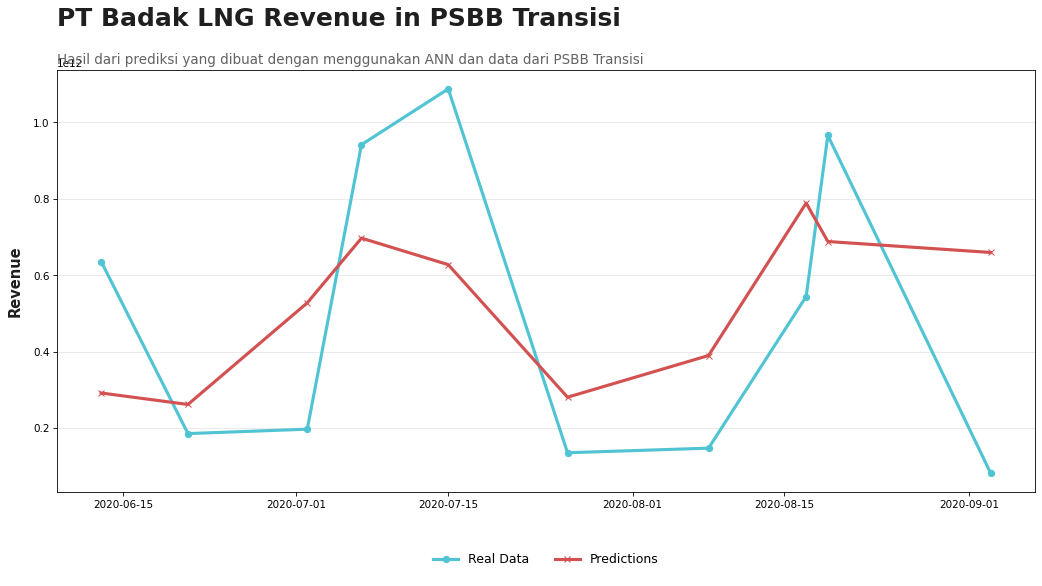

In [49]:
title_ann_standard = 'PT Badak LNG Revenue in PSBB Transisi'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PSBB Transisi'
plot_predictions(date_psbb_trans_2,revenue_psbb_trans_2_inv, revenue_psbb_trans_2_pred_inv, title_ann_standard, subtitle_ann_standard)

## PSBB KETAT

In [50]:
df_psbb_k_2 = df[df['Kebijakan'] == 'PSBB KETAT']
df_psbb_k_2

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
20,PSBB KETAT,9.0,1.155736e+11,2020-09-12,-0.482541,5,9,2020,0.833333,0.727273,0.0
21,PSBB KETAT,6.0,8.324162e+10,2020-09-18,-0.600828,4,9,2020,0.666667,0.727273,0.0
22,PSBB KETAT,5.0,7.156432e+10,2020-09-23,-0.643549,2,9,2020,0.333333,0.727273,0.0
23,PSBB KETAT,2.0,6.962526e+11,2020-09-25,1.641880,4,9,2020,0.666667,0.727273,0.0
24,PSBB KETAT,3.0,3.823324e+11,2020-09-28,0.493399,0,9,2020,0.000000,0.727273,0.0
25,PSBB KETAT,5.0,9.670782e+10,2020-10-03,-0.551562,5,10,2020,0.833333,0.818182,0.0
26,PSBB KETAT,6.0,3.794796e+11,2020-10-09,0.482962,4,10,2020,0.666667,0.818182,0.0
27,PSBB KETAT,2.0,3.770154e+11,2020-10-11,0.473947,6,10,2020,1.000000,0.818182,0.0


In [51]:
feature_psbb_k_2 = df_psbb_k_2[column_date_features]
revenue_psbb_k_2 = df_psbb_k_2['Revenue Scaled']

feature_psbb_k_2.shape, revenue_psbb_k_2.shape

((8, 3), (8,))

### Model

In [52]:
tf.random.set_seed(42)


# Build the model 
model_psbb_k_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(224, activation='tanh'),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(480, activation='relu'),
  tf.keras.layers.Dense(272, activation='relu'),
  tf.keras.layers.Dense(208, activation='relu'),
  tf.keras.layers.Dense(112, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear') 
])

# Compile the model
model_psbb_k_2.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_model_psbb_k_2 = model_psbb_k_2.fit(feature_psbb_k_2, revenue_psbb_k_2, batch_size=32, epochs=100, verbose=0, validation_split=0.25) 

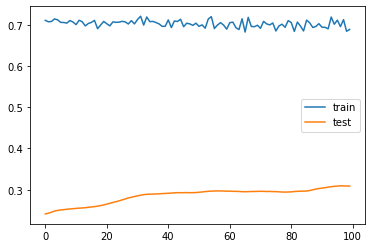

In [53]:
plt.plot(history_model_psbb_k_2.history['loss'], label='train')
plt.plot(history_model_psbb_k_2.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [54]:
revenUe_psbb_k_pred_2 = model_psbb_k_2.predict(feature_psbb_k_2)
revenUe_psbb_k_pred_2

array([[-0.07878131],
       [-0.05551013],
       [-0.01002383],
       [-0.05551013],
       [ 0.06849346],
       [-0.07564843],
       [-0.05417773],
       [-0.09960093]], dtype=float32)

In [55]:
revenue_psbb_k_2 = revenue_psbb_k_2.to_numpy()
revenue_psbb_k_2

array([-0.48254088, -0.60082778, -0.64354933,  1.64188024,  0.49339939,
       -0.55156153,  0.48296249,  0.47394721])

In [56]:
revenue_psbb_k_2_inv = revenue_scaler.inverse_transform(revenue_psbb_k_2.reshape(-1,1))
revenue_psbb_k_2_pred_inv = revenue_scaler.inverse_transform(revenUe_psbb_k_pred_2)
revenue_psbb_k_2_inv.shape, revenue_psbb_k_2_pred_inv.shape 

((8, 1), (8, 1))

In [57]:
MSE_psbb_k_2_Standard = mse(revenue_psbb_k_2_inv, revenue_psbb_k_2_pred_inv)
MAE_psbb_k_2_Standard = mae(revenue_psbb_k_2_inv, revenue_psbb_k_2_pred_inv)
r2_psbb_k_2 = r2_score(revenue_psbb_k_2_inv, revenue_psbb_k_2_pred_inv)
mape_psbb_k_2 = mean_absolute_percentage_error(revenue_psbb_k_2_inv, revenue_psbb_k_2_pred_inv)

print(f'Mean Squared Error : {MSE_psbb_k_2_Standard}')
print(f'Mean Absolute Error : {MAE_psbb_k_2_Standard}')
print(f'Coefficient of Determination : {r2_psbb_k_2}')
print(f'Mean Absolute Percentage Error : {mape_psbb_k_2}')


Mean Squared Error : 4.452279308176758e+22
Mean Absolute Error : 180794146816.0
Coefficient of Determination : -0.03044489725922861
Mean Absolute Percentage Error : 1.0354012657340543


### Visualization

In [58]:
revenue_psbb_k_2_inv = revenue_psbb_k_2_inv.squeeze()
revenue_psbb_k_2_pred_inv = revenue_psbb_k_2_pred_inv.squeeze()
date_psbb_k_2 = df_psbb_k_2['Tanggal']
date_psbb_k_2 = date_psbb_k_2.to_frame()

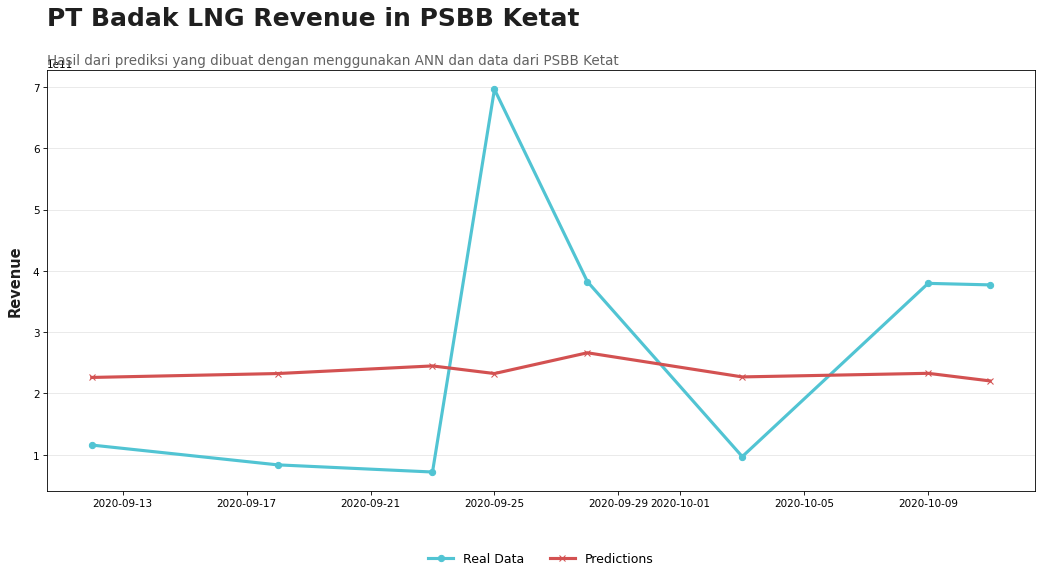

In [59]:
title_ann_standard = 'PT Badak LNG Revenue in PSBB Ketat'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PSBB Ketat'
plot_predictions(date_psbb_k_2,revenue_psbb_k_2_inv, revenue_psbb_k_2_pred_inv, title_ann_standard, subtitle_ann_standard)

## PSBB Transisi Fase 2

In [60]:
df_psbb_tf2_2 = df[df['Kebijakan'] == 'PSBB  TRANSISI FASE 2']
df_psbb_tf2_2

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
28,PSBB TRANSISI FASE 2,9.0,1.893239e+11,2020-10-20,-0.212725,1,10,2020,0.166667,0.818182,0.0
29,PSBB TRANSISI FASE 2,7.0,1.491147e+11,2020-10-27,-0.359831,1,10,2020,0.166667,0.818182,0.0
30,PSBB TRANSISI FASE 2,7.0,8.000991e+10,2020-11-03,-0.612651,1,11,2020,0.166667,0.909091,0.0
31,PSBB TRANSISI FASE 2,6.0,1.874729e+11,2020-11-09,-0.219496,0,11,2020,0.000000,0.909091,0.0
32,PSBB TRANSISI FASE 2,4.0,2.171203e+11,2020-11-13,-0.111031,4,11,2020,0.666667,0.909091,0.0
33,PSBB TRANSISI FASE 2,7.0,7.344057e+10,2020-11-20,-0.636685,4,11,2020,0.666667,0.909091,0.0
34,PSBB TRANSISI FASE 2,5.0,6.675399e+11,2020-11-25,1.536835,2,11,2020,0.333333,0.909091,0.0
35,PSBB TRANSISI FASE 2,10.0,9.461185e+10,2020-12-05,-0.559230,5,12,2020,0.833333,1.000000,0.0
36,PSBB TRANSISI FASE 2,15.0,4.613398e+10,2020-12-20,-0.736587,6,12,2020,1.000000,1.000000,0.0
37,PSBB TRANSISI FASE 2,5.0,1.520857e+11,2020-12-25,-0.348961,4,12,2020,0.666667,1.000000,0.0


In [61]:
feature_psbb_tf2_2 = df_psbb_tf2_2[column_date_features]
revenue_psbb_tf2_2 = df_psbb_tf2_2['Revenue Scaled']

feature_psbb_tf2_2.shape, revenue_psbb_tf2_2.shape

((10, 3), (10,))

### Model

In [62]:
tf.random.set_seed(42)


# Build the model 
model_psbb_tf2_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(224, activation='tanh'),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(480, activation='relu'),
  tf.keras.layers.Dense(272, activation='relu'),
  tf.keras.layers.Dense(208, activation='relu'),
  tf.keras.layers.Dense(112, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear') 
])

# Compile the model
model_psbb_tf2_2.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_model_psbb_tf2_2 = model_psbb_tf2_2.fit(feature_psbb_tf2_2, revenue_psbb_tf2_2, batch_size=32, epochs=100, verbose=0, validation_split=0.25) 

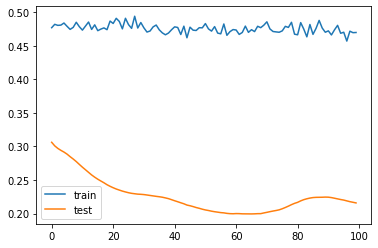

In [63]:
plt.plot(history_model_psbb_tf2_2.history['loss'], label='train')
plt.plot(history_model_psbb_tf2_2.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [64]:
revenUe_psbb_tf2_pred_2 = model_psbb_tf2_2.predict(feature_psbb_tf2_2)
revenUe_psbb_tf2_pred_2

array([[-0.06921861],
       [-0.06921861],
       [-0.07426402],
       [-0.08624401],
       [-0.09123386],
       [-0.09123386],
       [-0.06908315],
       [-0.10641687],
       [-0.12332013],
       [-0.0913707 ]], dtype=float32)

In [65]:
revenue_psbb_tf2_2 = revenue_psbb_tf2_2.to_numpy()
revenue_psbb_tf2_2

array([-0.21272466, -0.3598305 , -0.61265103, -0.21949649, -0.11103115,
       -0.63668505,  1.53683462, -0.55922966, -0.73658654, -0.34896103])

In [66]:
revenue_psbb_tf2_2_inv = revenue_scaler.inverse_transform(revenue_psbb_tf2_2.reshape(-1,1))
revenue_psbb_tf2_2_pred_inv = revenue_scaler.inverse_transform(revenUe_psbb_tf2_pred_2)
revenue_psbb_tf2_2_inv.shape, revenue_psbb_tf2_2_pred_inv.shape 

((10, 1), (10, 1))

In [67]:
MSE_psbb_tf2_2_Standard = mse(revenue_psbb_tf2_2_inv, revenue_psbb_tf2_2_pred_inv)
MAE_psbb_tf2_2_Standard = mae(revenue_psbb_tf2_2_inv, revenue_psbb_tf2_2_pred_inv)
r2_psbb_tf2_2 = r2_score(revenue_psbb_tf2_2_inv, revenue_psbb_tf2_2_pred_inv)
mape_psbb_tf2_2 = mean_absolute_percentage_error(revenue_psbb_tf2_2_inv, revenue_psbb_tf2_2_pred_inv)

print(f'Mean Squared Error : {MSE_psbb_tf2_2_Standard}')
print(f'Mean Absolute Error : {MAE_psbb_tf2_2_Standard}')
print(f'Coefficient of Determination : {r2_psbb_tf2_2}')
print(f'Mean Absolute Percentage Error : {mape_psbb_tf2_2}')


Mean Squared Error : 2.9414418793040076e+22
Mean Absolute Error : 125750394880.0
Coefficient of Determination : -0.02421483130853863
Mean Absolute Percentage Error : 1.08906561581433


### Visualization

In [68]:
revenue_psbb_tf2_2_inv = revenue_psbb_tf2_2_inv.squeeze()
revenue_psbb_tf2_2_pred_inv = revenue_psbb_tf2_2_pred_inv.squeeze()
date_psbb_tf2_2 = df_psbb_tf2_2['Tanggal']
date_psbb_tf2_2 = date_psbb_tf2_2.to_frame()

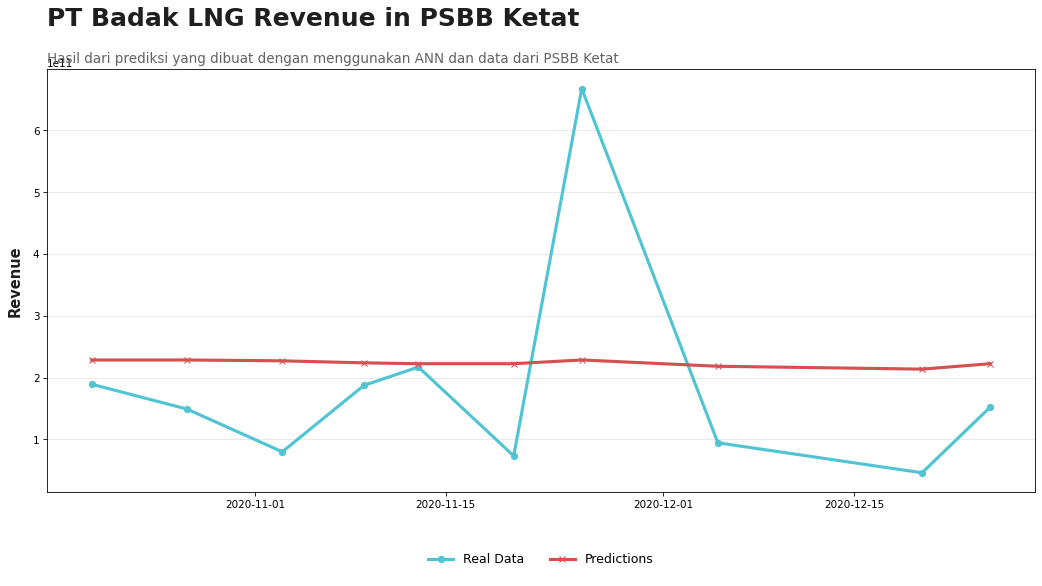

In [69]:
title_ann_standard = 'PT Badak LNG Revenue in PSBB Ketat'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PSBB Ketat'
plot_predictions(date_psbb_tf2_2,revenue_psbb_tf2_2_inv, revenue_psbb_tf2_2_pred_inv, title_ann_standard, subtitle_ann_standard)

## PPKM

In [70]:
df_ppkm_2 = df[df['Kebijakan'] == 'PPKM']
df_ppkm_2

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
38,PPKM,7.0,7.015936e+10,2021-01-06,-0.648689,2,1,2021,0.333333,0.000000,1.0
39,PPKM,2.0,1.059919e+12,2021-01-08,2.972357,4,1,2021,0.666667,0.000000,1.0
40,PPKM,5.0,8.244473e+10,2021-01-13,-0.603743,2,1,2021,0.333333,0.000000,1.0
41,PPKM,8.0,6.036486e+10,2021-01-21,-0.684523,3,1,2021,0.500000,0.000000,1.0
42,PPKM,2.0,7.427046e+11,2021-01-23,1.811825,5,1,2021,0.833333,0.000000,1.0
43,PPKM,9.0,1.100094e+11,2021-02-01,-0.502898,0,2,2021,0.000000,0.090909,1.0
44,PPKM,2.0,6.009249e+11,2021-02-03,1.293123,2,2,2021,0.333333,0.090909,1.0
45,PPKM,5.0,5.233691e+10,2021-02-08,-0.713893,0,2,2021,0.000000,0.090909,1.0


In [71]:
feature_ppkm_2 = df_ppkm_2[column_date_features]
revenue_ppkm_2 = df_ppkm_2['Revenue Scaled']

feature_ppkm_2.shape, revenue_ppkm_2.shape

((8, 3), (8,))

### Model

In [72]:
tf.random.set_seed(42)


# Build the model 
model_ppkm_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(224, activation='tanh'),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(480, activation='relu'),
  tf.keras.layers.Dense(272, activation='relu'),
  tf.keras.layers.Dense(208, activation='relu'),
  tf.keras.layers.Dense(112, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear') 
])

# Compile the model
model_ppkm_2.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_model_ppkm_2 = model_ppkm_2.fit(feature_ppkm_2, revenue_ppkm_2, batch_size=32, epochs=100, verbose=0, validation_split=0.25) 

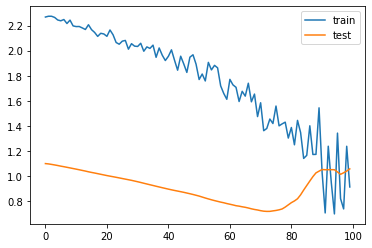

In [73]:
plt.plot(history_model_ppkm_2.history['loss'], label='train')
plt.plot(history_model_ppkm_2.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [74]:
revenUe_ppkm_pred_2 = model_ppkm_2.predict(feature_ppkm_2)
revenUe_ppkm_pred_2

array([[-0.1509518 ],
       [ 1.4232727 ],
       [-0.1509518 ],
       [ 0.64381063],
       [ 1.9424524 ],
       [-0.5148082 ],
       [-0.14736788],
       [-0.51480806]], dtype=float32)

In [75]:
revenue_ppkm_2 = revenue_ppkm_2.to_numpy()
revenue_ppkm_2

array([-0.6486894 ,  2.97235679, -0.60374322, -0.68452268,  1.81182541,
       -0.50289766,  1.29312264, -0.71389304])

In [76]:
revenue_ppkm_2_inv = revenue_scaler.inverse_transform(revenue_ppkm_2.reshape(-1,1))
revenue_ppkm_2_pred_inv = revenue_scaler.inverse_transform(revenUe_ppkm_pred_2)
revenue_ppkm_2_inv.shape, revenue_ppkm_2_pred_inv.shape 

((8, 1), (8, 1))

In [77]:
MSE_ppkm_2_Standard = mse(revenue_ppkm_2_inv, revenue_ppkm_2_pred_inv)
MAE_ppkm_2_Standard = mae(revenue_ppkm_2_inv, revenue_ppkm_2_pred_inv)
r2_ppkm_2 = r2_score(revenue_ppkm_2_inv, revenue_ppkm_2_pred_inv)
mape_ppkm_2 = mean_absolute_percentage_error(revenue_ppkm_2_inv, revenue_ppkm_2_pred_inv)

print(f'Mean Squared Error : {MSE_ppkm_2_Standard}')
print(f'Mean Absolute Error : {MAE_ppkm_2_Standard}')
print(f'Coefficient of Determination : {r2_ppkm_2}')
print(f'Mean Absolute Percentage Error : {mape_ppkm_2}')


Mean Squared Error : 6.302663379155294e+22
Mean Absolute Error : 191678316544.0
Coefficient of Determination : 0.542079367034224
Mean Absolute Percentage Error : 1.45339880534707


### Visualization

In [78]:
revenue_ppkm_2_inv = revenue_ppkm_2_inv.squeeze()
revenue_ppkm_2_pred_inv = revenue_ppkm_2_pred_inv.squeeze()
date_ppkm_2 = df_ppkm_2['Tanggal']
date_ppkm_2 = date_ppkm_2.to_frame()

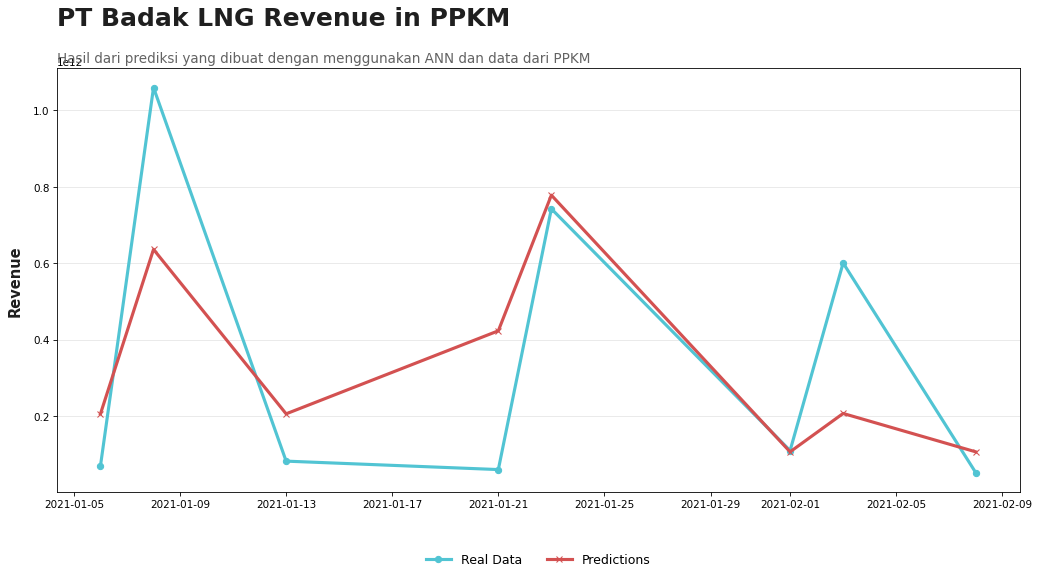

In [79]:
title_ann_standard = 'PT Badak LNG Revenue in PPKM'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PPKM'
plot_predictions(date_ppkm_2,revenue_ppkm_2_inv, revenue_ppkm_2_pred_inv, title_ann_standard, subtitle_ann_standard)

## PPKM MIKRO

In [80]:
df_ppkm_mikro_2 = df[df['Kebijakan'] == 'PPKM  MIKRO']
df_ppkm_mikro_2

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
46,PPKM MIKRO,6.0,7.329621e+10,2021-02-14,-0.637213,6,2,2021,1.000000,0.090909,1.0
47,PPKM MIKRO,4.0,1.576696e+11,2021-02-18,-0.328532,3,2,2021,0.500000,0.090909,1.0
48,PPKM MIKRO,3.0,5.125515e+11,2021-02-21,0.969807,6,2,2021,1.000000,0.090909,1.0
49,PPKM MIKRO,3.0,4.387788e+11,2021-02-24,0.699909,2,2,2021,0.333333,0.090909,1.0
50,PPKM MIKRO,5.0,6.246732e+10,2021-03-01,-0.676831,0,3,2021,0.000000,0.181818,1.0
51,PPKM MIKRO,3.0,4.248789e+11,2021-03-04,0.649056,3,3,2021,0.500000,0.181818,1.0
52,PPKM MIKRO,6.0,1.577392e+11,2021-03-10,-0.328278,2,3,2021,0.333333,0.181818,1.0
53,PPKM MIKRO,12.0,3.228827e+10,2021-03-22,-0.787241,0,3,2021,0.000000,0.181818,1.0
54,PPKM MIKRO,4.0,3.563277e+11,2021-03-26,0.398261,4,3,2021,0.666667,0.181818,1.0
55,PPKM MIKRO,5.0,4.487700e+11,2021-03-31,0.736462,2,3,2021,0.333333,0.181818,1.0


In [81]:
feature_ppkm_mikro_2 = df_ppkm_mikro_2[column_date_features]
revenue_ppkm_mikro_2 = df_ppkm_mikro_2['Revenue Scaled']

feature_ppkm_mikro_2.shape, revenue_ppkm_mikro_2.shape

((25, 3), (25,))

### Model

In [82]:
tf.random.set_seed(42)


# Build the model 
model_ppkm_mikro_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(224, activation='tanh'),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(480, activation='relu'),
  tf.keras.layers.Dense(272, activation='relu'),
  tf.keras.layers.Dense(208, activation='relu'),
  tf.keras.layers.Dense(112, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear') 
])

# Compile the model
model_ppkm_mikro_2.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_model_ppkm_mikro_2 = model_ppkm_mikro_2.fit(feature_ppkm_mikro_2, revenue_ppkm_mikro_2, batch_size=32, epochs=100, verbose=0, validation_split=0.25) 

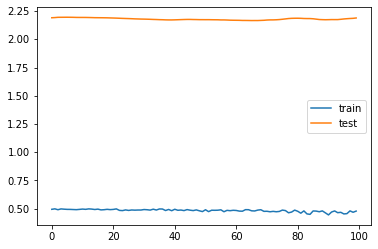

In [83]:
plt.plot(history_model_ppkm_mikro_2.history['loss'], label='train')
plt.plot(history_model_ppkm_mikro_2.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [84]:
revenUe_ppkm_mikro_pred_2 = model_ppkm_mikro_2.predict(feature_ppkm_mikro_2)
revenUe_ppkm_mikro_pred_2

array([[-0.13980275],
       [ 0.10900328],
       [-0.13980275],
       [ 0.14111733],
       [ 0.12287191],
       [ 0.06237707],
       [ 0.1269177 ],
       [ 0.12287191],
       [-0.02753317],
       [ 0.1269177 ],
       [-0.2388931 ],
       [ 0.12824476],
       [-0.08591123],
       [ 0.12210785],
       [-0.17001721],
       [ 0.1060927 ],
       [-0.27302554],
       [-0.05418014],
       [ 0.11853588],
       [ 0.11853588],
       [-0.25064534],
       [-0.25064534],
       [-0.02512875],
       [-0.1918869 ],
       [-0.02512877]], dtype=float32)

In [85]:
revenue_ppkm_mikro_2 = revenue_ppkm_mikro_2.to_numpy()
revenue_ppkm_mikro_2

array([-0.63721318, -0.32853202,  0.96980745,  0.69990916, -0.67683083,
        0.64905643, -0.32827761, -0.78724121,  0.39826085,  0.73646218,
       -0.40222175,  1.38354256, -0.63813185,  1.00151706, -0.32984154,
       -0.77123464, -0.36481776, -0.60620641,  2.46703072, -0.64517891,
        1.1863331 , -0.43312055,  2.59774929, -0.60565411, -0.29334398])

In [86]:
revenue_ppkm_mikro_2_inv = revenue_scaler.inverse_transform(revenue_ppkm_mikro_2.reshape(-1,1))
revenue_ppkm_mikro_2_pred_inv = revenue_scaler.inverse_transform(revenUe_ppkm_mikro_pred_2)
revenue_ppkm_mikro_2_inv.shape, revenue_ppkm_mikro_2_pred_inv.shape 

((25, 1), (25, 1))

In [87]:
MSE_ppkm_mikro_2_Standard = mse(revenue_ppkm_mikro_2_inv, revenue_ppkm_mikro_2_pred_inv)
MAE_ppkm_mikro_2_Standard = mae(revenue_ppkm_mikro_2_inv, revenue_ppkm_mikro_2_pred_inv)
r2_ppkm_mikro_2 = r2_score(revenue_ppkm_mikro_2_inv, revenue_ppkm_mikro_2_pred_inv)
mape_ppkm_mikro_2 = mean_absolute_percentage_error(revenue_ppkm_mikro_2_inv, revenue_ppkm_mikro_2_pred_inv)

print(f'Mean Squared Error : {MSE_ppkm_mikro_2_Standard}')
print(f'Mean Absolute Error : {MAE_ppkm_mikro_2_Standard}')
print(f'Coefficient of Determination : {r2_ppkm_mikro_2}')
print(f'Mean Absolute Percentage Error : {mape_ppkm_mikro_2}')


Mean Squared Error : 7.07168003712657e+22
Mean Absolute Error : 207276933120.0
Coefficient of Determination : -0.006016803412203453
Mean Absolute Percentage Error : 1.4451080042519657


### Visualization

In [88]:
revenue_ppkm_mikro_2_inv = revenue_ppkm_mikro_2_inv.squeeze()
revenue_ppkm_mikro_2_pred_inv = revenue_ppkm_mikro_2_pred_inv.squeeze()
date_ppkm_mikro_2 = df_ppkm_mikro_2['Tanggal']
date_ppkm_mikro_2 = date_ppkm_mikro_2.to_frame()

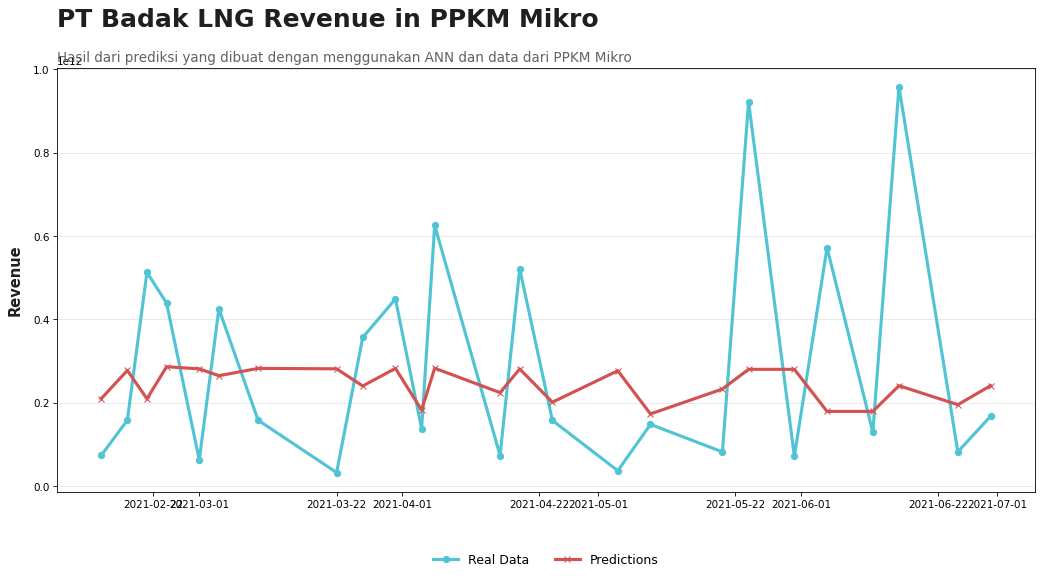

In [89]:
title_ann_standard = 'PT Badak LNG Revenue in PPKM Mikro'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PPKM Mikro'
plot_predictions(date_ppkm_mikro_2,revenue_ppkm_mikro_2_inv, revenue_ppkm_mikro_2_pred_inv, title_ann_standard, subtitle_ann_standard)

## PPKM DARURAT

In [205]:
df_ppkm_darurat_2 = df[df['Kebijakan'] == 'PPKM DARURAT']
df_ppkm_darurat_2

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
71,PPKM DARURAT,3.0,3.146886e+11,2021-07-03,0.245924,5,7,2021,0.833333,0.545455,1.0
72,PPKM DARURAT,4.0,3.682184e+10,2021-07-07,-0.770655,2,7,2021,0.333333,0.545455,1.0
73,PPKM DARURAT,3.0,3.772735e+11,2021-07-10,0.474891,5,7,2021,0.833333,0.545455,1.0
74,PPKM DARURAT,3.0,4.029332e+10,2021-07-13,-0.757955,1,7,2021,0.166667,0.545455,1.0
75,PPKM DARURAT,1.0,4.859427e+10,2021-07-14,-0.727586,2,7,2021,0.333333,0.545455,1.0
76,PPKM DARURAT,3.0,3.779995e+10,2021-07-17,-0.767077,5,7,2021,0.833333,0.545455,1.0
77,PPKM DARURAT,2.0,4.150306e+10,2021-07-19,-0.753529,0,7,2021,0.000000,0.545455,1.0
78,PPKM DARURAT,1.0,1.318172e+11,2021-07-20,-0.423114,1,7,2021,0.166667,0.545455,1.0


In [206]:
feature_ppkm_darurat_2 = df_ppkm_darurat_2[column_date_features]
revenue_ppkm_darurat_2 = df_ppkm_darurat_2['Revenue Scaled']

feature_ppkm_darurat_2.shape, revenue_ppkm_darurat_2.shape

((8, 3), (8,))

### Model

In [207]:
tf.random.set_seed(42)


# Build the model 
model_ppkm_darurat_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(224, activation='tanh'),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(480, activation='relu'),
  tf.keras.layers.Dense(272, activation='relu'),
  tf.keras.layers.Dense(208, activation='relu'),
  tf.keras.layers.Dense(112, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear') 
])

# Compile the model
model_ppkm_darurat_2.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_model_ppkm_darurat_2 = model_ppkm_darurat_2.fit(feature_ppkm_darurat_2, revenue_ppkm_darurat_2, batch_size=32, epochs=100, verbose=0, validation_split=0.25) 

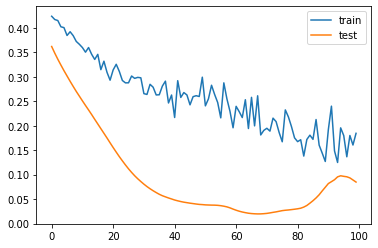

In [208]:
plt.plot(history_model_ppkm_darurat_2.history['loss'], label='train')
plt.plot(history_model_ppkm_darurat_2.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [209]:
revenUe_ppkm_darurat_pred_2 = model_ppkm_darurat_2.predict(feature_ppkm_darurat_2)
revenUe_ppkm_darurat_pred_2

array([[ 0.01596451],
       [-0.61628056],
       [ 0.01596451],
       [-0.8037161 ],
       [-0.61628056],
       [ 0.01596451],
       [-0.91076636],
       [-0.80371606]], dtype=float32)

In [210]:
revenue_ppkm_darurat_2 = revenue_ppkm_darurat_2.to_numpy()
revenue_ppkm_darurat_2

array([ 0.24592371, -0.77065511,  0.47489131, -0.75795467, -0.72758553,
       -0.7670767 , -0.75352881, -0.42311354])

In [211]:
revenue_ppkm_darurat_2_inv = revenue_scaler.inverse_transform(revenue_ppkm_darurat_2.reshape(-1,1))
revenue_ppkm_darurat_2_pred_inv = revenue_scaler.inverse_transform(revenUe_ppkm_darurat_pred_2)
revenue_ppkm_darurat_2_inv.shape, revenue_ppkm_darurat_2_pred_inv.shape 

((8, 1), (8, 1))

In [212]:
MSE_ppkm_darurat_2_Standard = mse(revenue_ppkm_darurat_2_inv, revenue_ppkm_darurat_2_pred_inv)
MAE_ppkm_darurat_2_Standard = mae(revenue_ppkm_darurat_2_inv, revenue_ppkm_darurat_2_pred_inv)
r2_ppkm_darurat_2 = r2_score(revenue_ppkm_darurat_2_inv, revenue_ppkm_darurat_2_pred_inv)
mape_ppkm_darurat_2 = mean_absolute_percentage_error(revenue_ppkm_darurat_2_inv, revenue_ppkm_darurat_2_pred_inv)

print(f'Mean Squared Error : {MSE_ppkm_darurat_2_Standard}')
print(f'Mean Absolute Error : {MAE_ppkm_darurat_2_Standard}')
print(f'Coefficient of Determination : {r2_ppkm_darurat_2}')
print(f'Mean Absolute Percentage Error : {mape_ppkm_darurat_2}')


Mean Squared Error : 1.0128582051157363e+22
Mean Absolute Error : 79308488704.0
Coefficient of Determination : 0.3994789176163396
Mean Absolute Percentage Error : 1.2627125770678833


### Visualization

In [213]:
revenue_ppkm_darurat_2_inv = revenue_ppkm_darurat_2_inv.squeeze()
revenue_ppkm_darurat_2_pred_inv = revenue_ppkm_darurat_2_pred_inv.squeeze()
date_ppkm_darurat_2 = df_ppkm_darurat_2['Tanggal']
date_ppkm_darurat_2 = date_ppkm_darurat_2.to_frame()

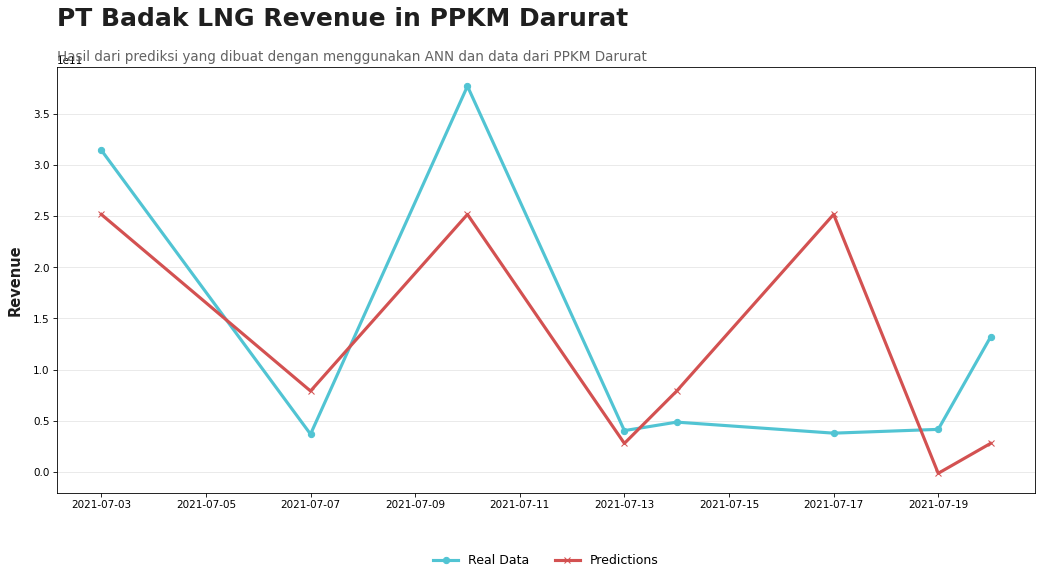

In [214]:
title_ann_standard = 'PT Badak LNG Revenue in PPKM Darurat'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PPKM Darurat'
plot_predictions(date_ppkm_darurat_2,revenue_ppkm_darurat_2_inv, revenue_ppkm_darurat_2_pred_inv, title_ann_standard, subtitle_ann_standard)

## PPKM LEVEL 3 & 4

In [215]:
df_ppkm_34_2 = df[df['Kebijakan'] == 'PPKM LEVEL 3 & 4']
df_ppkm_34_2

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
79,PPKM LEVEL 3 & 4,3.0,7.431663e+11,2021-07-23,1.813514,4,7,2021,0.666667,0.545455,1.0
80,PPKM LEVEL 3 & 4,4.0,4.606025e+10,2021-07-27,-0.736856,1,7,2021,0.166667,0.545455,1.0
81,PPKM LEVEL 3 & 4,6.0,3.508969e+10,2021-08-02,-0.776992,0,8,2021,0.000000,0.636364,1.0
82,PPKM LEVEL 3 & 4,5.0,3.969734e+10,2021-08-07,-0.760135,5,8,2021,0.833333,0.636364,1.0
83,PPKM LEVEL 3 & 4,2.0,1.024295e+11,2021-08-09,-0.530629,0,8,2021,0.000000,0.636364,1.0
84,PPKM LEVEL 3 & 4,6.0,4.888114e+10,2021-08-15,-0.726536,6,8,2021,1.000000,0.636364,1.0
85,PPKM LEVEL 3 & 4,4.0,4.675836e+10,2021-08-19,-0.734302,3,8,2021,0.500000,0.636364,1.0
86,PPKM LEVEL 3 & 4,3.0,7.862788e+10,2021-08-22,-0.617707,6,8,2021,1.000000,0.636364,1.0


In [216]:
feature_ppkm_34_2 = df_ppkm_34_2[column_date_features]
revenue_ppkm_34_2 = df_ppkm_34_2['Revenue Scaled']

feature_ppkm_34_2.shape, revenue_ppkm_34_2.shape

((8, 3), (8,))

### Model

In [217]:
tf.random.set_seed(42)


# Build the model 
model_ppkm_34_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(224, activation='tanh'),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(480, activation='relu'),
  tf.keras.layers.Dense(272, activation='relu'),
  tf.keras.layers.Dense(208, activation='relu'),
  tf.keras.layers.Dense(112, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear') 
])

# Compile the model
model_ppkm_34_2.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_model_ppkm_34_2 = model_ppkm_34_2.fit(feature_ppkm_34_2, revenue_ppkm_34_2, batch_size=32, epochs=100, verbose=0, validation_split=0.25) 

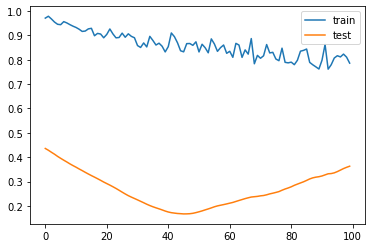

In [218]:
plt.plot(history_model_ppkm_34_2.history['loss'], label='train')
plt.plot(history_model_ppkm_34_2.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [219]:
revenUe_ppkm_34_pred_2 = model_ppkm_34_2.predict(feature_ppkm_34_2)
revenUe_ppkm_34_pred_2

array([[-0.0385481 ],
       [-0.38452062],
       [-0.5523024 ],
       [-0.03526758],
       [-0.5523024 ],
       [-0.0364324 ],
       [-0.11118214],
       [-0.03643239]], dtype=float32)

In [220]:
revenue_ppkm_34_2 = revenue_ppkm_34_2.to_numpy()
revenue_ppkm_34_2

array([ 1.81351442, -0.73685627, -0.77699219, -0.76013506, -0.53062882,
       -0.726536  , -0.73430223, -0.61770722])

In [221]:
revenue_ppkm_34_2_inv = revenue_scaler.inverse_transform(revenue_ppkm_34_2.reshape(-1,1))
revenue_ppkm_34_2_pred_inv = revenue_scaler.inverse_transform(revenUe_ppkm_34_pred_2)
revenue_ppkm_34_2_inv.shape, revenue_ppkm_34_2_pred_inv.shape 

((8, 1), (8, 1))

In [223]:
MSE_ppkm_34_2_Standard = mse(revenue_ppkm_34_2_inv, revenue_ppkm_34_2_pred_inv)
MAE_ppkm_34_2_Standard = mae(revenue_ppkm_34_2_inv, revenue_ppkm_34_2_pred_inv)
r2_ppkm_34_2 = r2_score(revenue_ppkm_34_2_inv, revenue_ppkm_34_2_pred_inv)
mape_ppkm_34_2 = mean_absolute_percentage_error(revenue_ppkm_34_2_inv, revenue_ppkm_34_2_pred_inv)

print(f'Mean Squared Error : {MSE_ppkm_34_2_Standard}')
print(f'Mean Absolute Error : {MAE_ppkm_34_2_Standard}')
print(f'Coefficient of Determination : {r2_ppkm_34_2}')
print(f'Mean Absolute Percentage Error : {mape_ppkm_34_2}')


Mean Squared Error : 4.980557849506796e+22
Mean Absolute Error : 173230522368.0
Coefficient of Determination : 0.0417906303510206
Mean Absolute Percentage Error : 2.386674967283181


### Visualization

In [224]:
revenue_ppkm_34_2_inv = revenue_ppkm_34_2_inv.squeeze()
revenue_ppkm_34_2_pred_inv = revenue_ppkm_34_2_pred_inv.squeeze()
date_ppkm_34_2 = df_ppkm_34_2['Tanggal']
date_ppkm_34_2 = date_ppkm_34_2.to_frame()

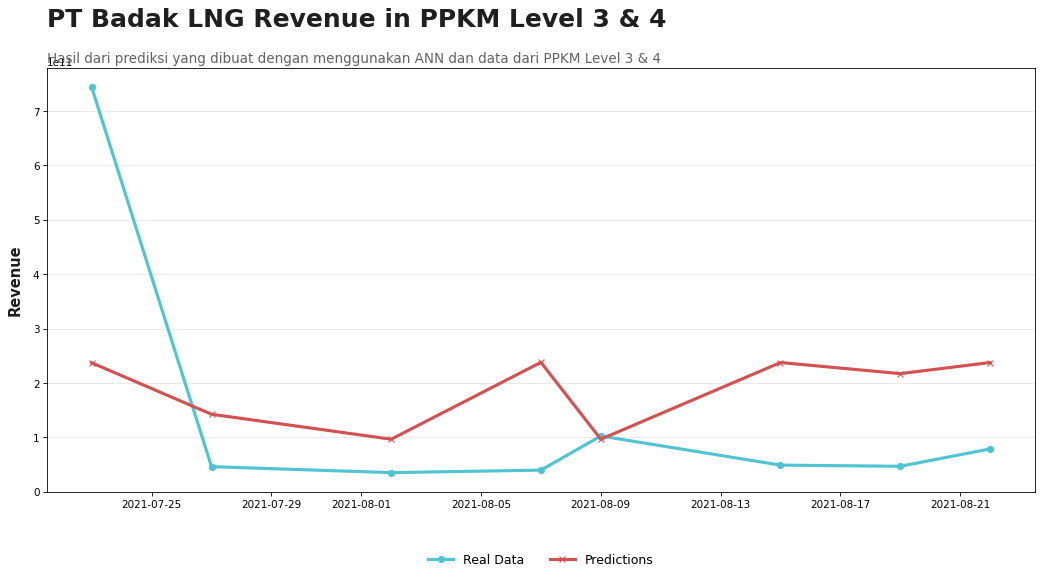

In [225]:
title_ann_standard = 'PT Badak LNG Revenue in PPKM Level 3 & 4'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PPKM Level 3 & 4'
plot_predictions(date_ppkm_34_2,revenue_ppkm_34_2_inv, revenue_ppkm_34_2_pred_inv, title_ann_standard, subtitle_ann_standard)

## PPKM LEVEL 2, 3, & 4

In [226]:
df_ppkm_234_2 = df[df['Kebijakan'] == 'PPKM LEVEL 2, 3, & 4']
df_ppkm_234_2

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
87,"PPKM LEVEL 2, 3, & 4",3.0,7.450172e+10,2021-08-25,-0.632803,2,8,2021,0.333333,0.636364,1.0
88,"PPKM LEVEL 2, 3, & 4",6.0,3.437665e+10,2021-08-31,-0.779601,1,8,2021,0.166667,0.636364,1.0
89,"PPKM LEVEL 2, 3, & 4",3.0,3.002385e+10,2021-09-03,-0.795526,4,9,2021,0.666667,0.727273,1.0
90,"PPKM LEVEL 2, 3, & 4",3.0,3.878350e+11,2021-09-06,0.513531,0,9,2021,0.000000,0.727273,1.0
91,"PPKM LEVEL 2, 3, & 4",5.0,3.872531e+10,2021-09-11,-0.763691,5,9,2021,0.833333,0.727273,1.0
92,"PPKM LEVEL 2, 3, & 4",4.0,7.181793e+10,2021-09-15,-0.642622,2,9,2021,0.333333,0.727273,1.0
93,"PPKM LEVEL 2, 3, & 4",4.0,4.041351e+10,2021-09-19,-0.757515,6,9,2021,1.000000,0.727273,1.0
94,"PPKM LEVEL 2, 3, & 4",5.0,3.464876e+10,2021-09-24,-0.778605,4,9,2021,0.666667,0.727273,1.0
95,"PPKM LEVEL 2, 3, & 4",6.0,2.898548e+10,2021-09-30,-0.799325,3,9,2021,0.500000,0.727273,1.0
96,"PPKM LEVEL 2, 3, & 4",7.0,2.594012e+10,2021-10-07,-0.810466,3,10,2021,0.500000,0.818182,1.0


In [228]:
feature_ppkm_234_2 = df_ppkm_234_2[column_date_features]
revenue_ppkm_234_2 = df_ppkm_234_2['Revenue Scaled']

feature_ppkm_234_2.shape, revenue_ppkm_234_2.shape

((10, 3), (10,))

### Model

In [229]:
tf.random.set_seed(42)


# Build the model 
model_ppkm_234_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(224, activation='tanh'),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(480, activation='relu'),
  tf.keras.layers.Dense(272, activation='relu'),
  tf.keras.layers.Dense(208, activation='relu'),
  tf.keras.layers.Dense(112, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear') 
])

# Compile the model
model_ppkm_234_2.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_model_ppkm_234_2 = model_ppkm_234_2.fit(feature_ppkm_234_2, revenue_ppkm_234_2, batch_size=32, epochs=100, verbose=0, validation_split=0.25) 

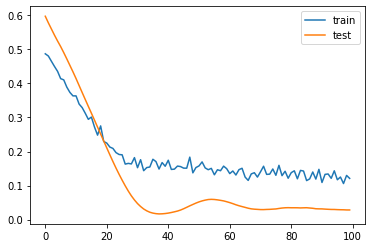

In [230]:
plt.plot(history_model_ppkm_234_2.history['loss'], label='train')
plt.plot(history_model_ppkm_234_2.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [231]:
revenUe_ppkm_234_pred_2 = model_ppkm_234_2.predict(feature_ppkm_234_2)
revenUe_ppkm_234_pred_2

array([[-0.49143717],
       [-0.36281663],
       [-0.70152813],
       [-0.23562887],
       [-0.79272425],
       [-0.4937889 ],
       [-0.88266534],
       [-0.70152813],
       [-0.6051634 ],
       [-0.60862726]], dtype=float32)

In [232]:
revenue_ppkm_234_2 = revenue_ppkm_234_2.to_numpy()
revenue_ppkm_234_2

array([-0.63280282, -0.77960087, -0.79552564,  0.51353073, -0.76369122,
       -0.64262151, -0.75751493, -0.77860535, -0.79932453, -0.810466  ])

In [233]:
revenue_ppkm_234_2_inv = revenue_scaler.inverse_transform(revenue_ppkm_234_2.reshape(-1,1))
revenue_ppkm_234_2_pred_inv = revenue_scaler.inverse_transform(revenUe_ppkm_234_pred_2)
revenue_ppkm_234_2_inv.shape, revenue_ppkm_234_2_pred_inv.shape 

((10, 1), (10, 1))

In [234]:
MSE_ppkm_234_2_Standard = mse(revenue_ppkm_234_2_inv, revenue_ppkm_234_2_pred_inv)
MAE_ppkm_234_2_Standard = mae(revenue_ppkm_234_2_inv, revenue_ppkm_234_2_pred_inv)
r2_ppkm_234_2 = r2_score(revenue_ppkm_234_2_inv, revenue_ppkm_234_2_pred_inv)
mape_ppkm_234_2 = mean_absolute_percentage_error(revenue_ppkm_234_2_inv, revenue_ppkm_234_2_pred_inv)

print(f'Mean Squared Error : {MSE_ppkm_234_2_Standard}')
print(f'Mean Absolute Error : {MAE_ppkm_234_2_Standard}')
print(f'Coefficient of Determination : {r2_ppkm_234_2}')
print(f'Mean Absolute Percentage Error : {mape_ppkm_234_2}')


Mean Squared Error : 6.625500428153637e+21
Mean Absolute Error : 59516006400.0
Coefficient of Determination : 0.3986871543596633
Mean Absolute Percentage Error : 1.1399936865706772


### Visualization

In [235]:
revenue_ppkm_234_2_inv = revenue_ppkm_234_2_inv.squeeze()
revenue_ppkm_234_2_pred_inv = revenue_ppkm_234_2_pred_inv.squeeze()
date_ppkm_234_2 = df_ppkm_234_2['Tanggal']
date_ppkm_234_2 = date_ppkm_234_2.to_frame()

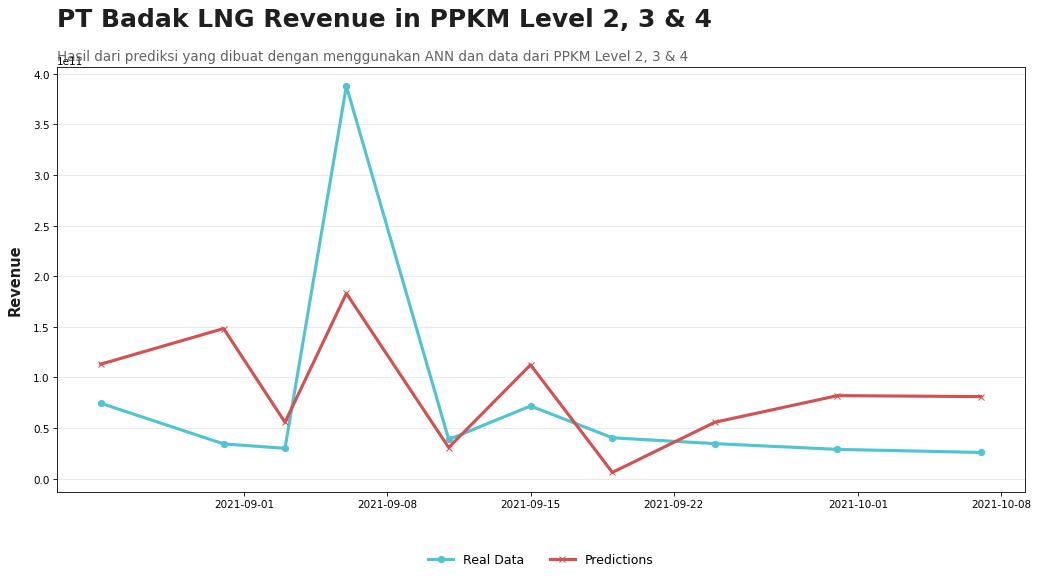

In [236]:
title_ann_standard = 'PT Badak LNG Revenue in PPKM Level 2, 3 & 4'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PPKM Level 2, 3 & 4'
plot_predictions(date_ppkm_234_2,revenue_ppkm_234_2_inv, revenue_ppkm_234_2_pred_inv, title_ann_standard, subtitle_ann_standard)

## PPKM LEVEL 1, 2, & 3

In [237]:
df_ppkm_123_2 = df[df['Kebijakan'] == 'PPKM  LEVEL 1, 2, & 3']
df_ppkm_123_2

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
97,"PPKM LEVEL 1, 2, & 3",12.0,1.732555e+11,2021-10-19,-0.271511,1,10,2021,0.166667,0.818182,1.0
98,"PPKM LEVEL 1, 2, & 3",8.0,3.539399e+10,2021-10-27,-0.775879,2,10,2021,0.333333,0.818182,1.0
99,"PPKM LEVEL 1, 2, & 3",9.0,3.257680e+10,2021-11-05,-0.786186,4,11,2021,0.666667,0.909091,1.0
100,"PPKM LEVEL 1, 2, & 3",3.0,6.923571e+11,2021-11-08,1.627628,0,11,2021,0.000000,0.909091,1.0
101,"PPKM LEVEL 1, 2, & 3",7.0,3.670740e+10,2021-11-15,-0.771074,0,11,2021,0.000000,0.909091,1.0
102,"PPKM LEVEL 1, 2, & 3",8.0,3.308818e+10,2021-11-23,-0.784315,1,11,2021,0.166667,0.909091,1.0
103,"PPKM LEVEL 1, 2, & 3",2.0,9.634531e+10,2021-11-25,-0.552888,3,11,2021,0.500000,0.909091,1.0
104,"PPKM LEVEL 1, 2, & 3",9.0,3.496118e+10,2021-12-04,-0.777462,5,12,2021,0.833333,1.000000,1.0
105,"PPKM LEVEL 1, 2, & 3",8.0,3.284880e+10,2021-12-12,-0.785191,6,12,2021,1.000000,1.000000,1.0
106,"PPKM LEVEL 1, 2, & 3",7.0,1.610741e+11,2021-12-19,-0.316077,6,12,2021,1.000000,1.000000,1.0


In [238]:
feature_ppkm_123_2 = df_ppkm_123_2[column_date_features]
revenue_ppkm_123_2 = df_ppkm_123_2['Revenue Scaled']

feature_ppkm_123_2.shape, revenue_ppkm_123_2.shape

((10, 3), (10,))

### Model

In [239]:
tf.random.set_seed(42)


# Build the model 
model_ppkm_123_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(224, activation='tanh'),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(480, activation='relu'),
  tf.keras.layers.Dense(272, activation='relu'),
  tf.keras.layers.Dense(208, activation='relu'),
  tf.keras.layers.Dense(112, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear') 
])

# Compile the model
model_ppkm_123_2.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_model_ppkm_123_2 = model_ppkm_123_2.fit(feature_ppkm_123_2, revenue_ppkm_123_2, batch_size=32, epochs=100, verbose=0, validation_split=0.25) 

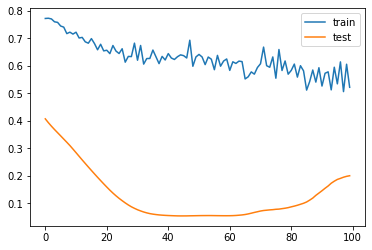

In [240]:
plt.plot(history_model_ppkm_123_2.history['loss'], label='train')
plt.plot(history_model_ppkm_123_2.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [241]:
revenUe_ppkm_123_pred_2 = model_ppkm_123_2.predict(feature_ppkm_123_2)
revenUe_ppkm_123_pred_2

array([[-0.26135793],
       [-0.4608717 ],
       [-0.7764799 ],
       [-0.0750127 ],
       [-0.0750127 ],
       [-0.26101616],
       [-0.626959  ],
       [-0.9128366 ],
       [-1.0373127 ],
       [-1.0373127 ]], dtype=float32)

In [242]:
revenue_ppkm_123_2 = revenue_ppkm_123_2.to_numpy()
revenue_ppkm_123_2

array([-0.27151108, -0.77587893, -0.78618562,  1.62762838, -0.7710738 ,
       -0.78431474, -0.55288778, -0.77746235, -0.78519053, -0.31607668])

In [243]:
revenue_ppkm_123_2_inv = revenue_scaler.inverse_transform(revenue_ppkm_123_2.reshape(-1,1))
revenue_ppkm_123_2_pred_inv = revenue_scaler.inverse_transform(revenUe_ppkm_123_pred_2)
revenue_ppkm_123_2_inv.shape, revenue_ppkm_123_2_pred_inv.shape 

((10, 1), (10, 1))

In [244]:
MSE_ppkm_123_2_Standard = mse(revenue_ppkm_123_2_inv, revenue_ppkm_123_2_pred_inv)
MAE_ppkm_123_2_Standard = mae(revenue_ppkm_123_2_inv, revenue_ppkm_123_2_pred_inv)
r2_ppkm_123_2 = r2_score(revenue_ppkm_123_2_inv, revenue_ppkm_123_2_pred_inv)
mape_ppkm_123_2 = mean_absolute_percentage_error(revenue_ppkm_123_2_inv, revenue_ppkm_123_2_pred_inv)

print(f'Mean Squared Error : {MSE_ppkm_123_2_Standard}')
print(f'Mean Absolute Error : {MAE_ppkm_123_2_Standard}')
print(f'Coefficient of Determination : {r2_ppkm_123_2}')
print(f'Mean Absolute Percentage Error : {mape_ppkm_123_2}')


Mean Squared Error : 3.2606723331307615e+22
Mean Absolute Error : 121351806976.0
Coefficient of Determination : 0.1308132202342147
Mean Absolute Percentage Error : 1.7298640372406886


### Visualization

In [245]:
revenue_ppkm_123_2_inv = revenue_ppkm_123_2_inv.squeeze()
revenue_ppkm_123_2_pred_inv = revenue_ppkm_123_2_pred_inv.squeeze()
date_ppkm_123_2 = df_ppkm_123_2['Tanggal']
date_ppkm_123_2 = date_ppkm_123_2.to_frame()

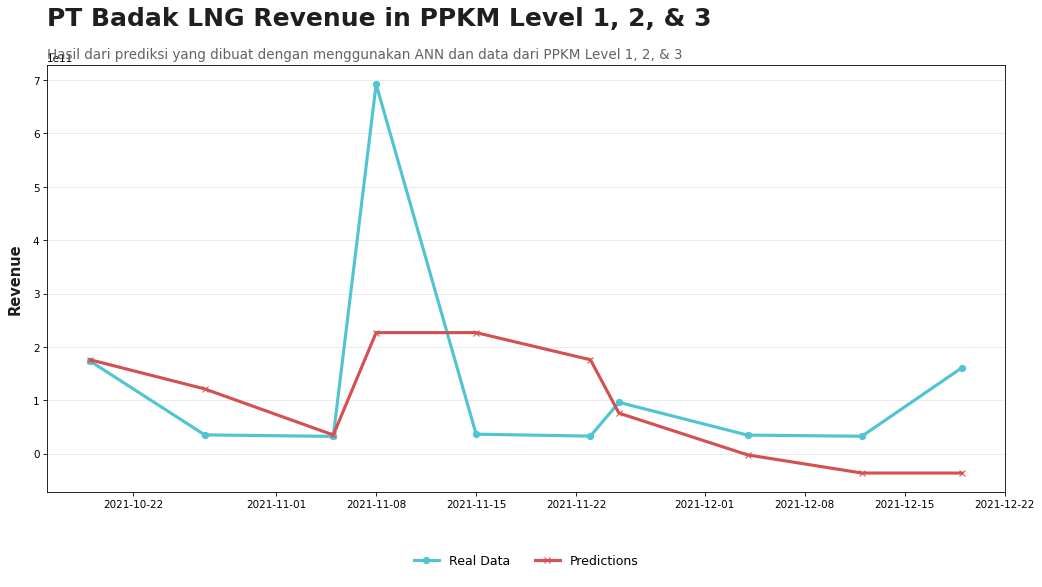

In [246]:
title_ann_standard = 'PT Badak LNG Revenue in PPKM Level 1, 2, & 3'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PPKM Level 1, 2, & 3'
plot_predictions(date_ppkm_123_2,revenue_ppkm_123_2_inv, revenue_ppkm_123_2_pred_inv, title_ann_standard, subtitle_ann_standard)

# Model with Periode as Feature

## PSBB

In [90]:
df_psbb = df[df['Kebijakan'] == 'PSBB']
df_psbb

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
0,PSBB,10.0,1.561507e+11,2020-04-10,-0.334089,4,4,2020,0.666667,0.272727,0.0
1,PSBB,2.0,6.774117e+11,2020-04-12,1.572951,6,4,2020,1.000000,0.272727,0.0
2,PSBB,8.0,1.472724e+11,2020-04-20,-0.366570,0,4,2020,0.000000,0.272727,0.0
3,PSBB,5.0,1.832997e+11,2020-04-25,-0.234764,5,4,2020,0.833333,0.272727,0.0
4,PSBB,5.0,8.791090e+11,2020-04-30,2.310863,3,4,2020,0.500000,0.272727,0.0
5,PSBB,10.0,1.474547e+11,2020-05-10,-0.365904,6,5,2020,1.000000,0.363636,0.0
6,PSBB,8.0,1.760403e+11,2020-05-18,-0.261323,0,5,2020,0.000000,0.363636,0.0
7,PSBB,7.0,1.758892e+11,2020-05-25,-0.261876,0,5,2020,0.000000,0.363636,0.0
8,PSBB,7.0,1.432047e+11,2020-06-01,-0.381452,0,6,2020,0.000000,0.454545,0.0
9,PSBB,2.0,4.195147e+11,2020-06-03,0.629431,2,6,2020,0.333333,0.454545,0.0


In [91]:
feature_psbb_1 = df_psbb['Periode (hari)']
revenue_psbb_1 = df_psbb['Revenue Scaled']

feature_psbb_1.shape, revenue_psbb_1.shape

((10,), (10,))

#### Model

In [92]:
tf.random.set_seed(42)


# Build the model 
model_psbb_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10), 
  tf.keras.layers.Dense(1) 
])

# Compile the model
model_psbb_1.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_psbb_1 = model_psbb_1.fit(feature_psbb_1, revenue_psbb_1, batch_size=32, epochs=100, verbose=0, validation_split=0.3, shuffle=False) 

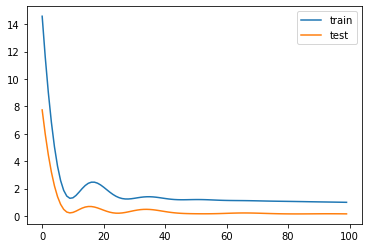

In [93]:
plt.plot(history_psbb_1.history['loss'], label='train')
plt.plot(history_psbb_1.history['val_loss'], label='test')
plt.legend();

#### Evaluation

In [94]:
revenUe_psbb_pred_1 = model_psbb_1.predict(feature_psbb_1)
revenUe_psbb_pred_1

array([[-0.01748252],
       [ 0.26692498],
       [ 0.05361921],
       [ 0.16027218],
       [ 0.16027218],
       [-0.01748252],
       [ 0.05361921],
       [ 0.08917048],
       [ 0.08917048],
       [ 0.26692498]], dtype=float32)

In [95]:
revenue_psbb_1 = revenue_psbb_1.to_numpy()
revenue_psbb_1

array([-0.33408906,  1.5729506 , -0.36657031, -0.23476395,  2.3108625 ,
       -0.36590357, -0.26132273, -0.26187564, -0.38145209,  0.62943115])

In [96]:
revenue_psbb_1_inv = revenue_scaler.inverse_transform(revenue_psbb_1.reshape(-1,1))
revenue_psbb_1_pred_inv = revenue_scaler.inverse_transform(revenUe_psbb_pred_1)
revenue_psbb_1_inv.shape, revenue_psbb_1_pred_inv.shape 

((10, 1), (10, 1))

In [97]:
MSE_psbb_1_Standard = mse(revenue_psbb_1_inv, revenue_psbb_1_pred_inv)
MAE_psbb_1_Standard = mae(revenue_psbb_1_inv, revenue_psbb_1_pred_inv)
r2_psbb_1 = r2_score(revenue_psbb_1_inv, revenue_psbb_1_pred_inv)

print(f'Mean Squared Error : {MSE_psbb_1_Standard}')
print(f'Mean Absolute Error : {MAE_psbb_1_Standard}')
print(f'Coefficient of Determination : {r2_psbb_1}')

Mean Squared Error : 5.5737548787454535e+22
Mean Absolute Error : 175918120960.0
Coefficient of Determination : 0.11138739453980528


### Visualization

In [98]:
revenue_psbb_1_inv = revenue_psbb_1_inv.squeeze()
revenue_psbb_1_pred_inv = revenue_psbb_1_pred_inv.squeeze()
date_psbb_1 = df_psbb['Tanggal']
date_psbb_1 = date_psbb_1.to_frame()

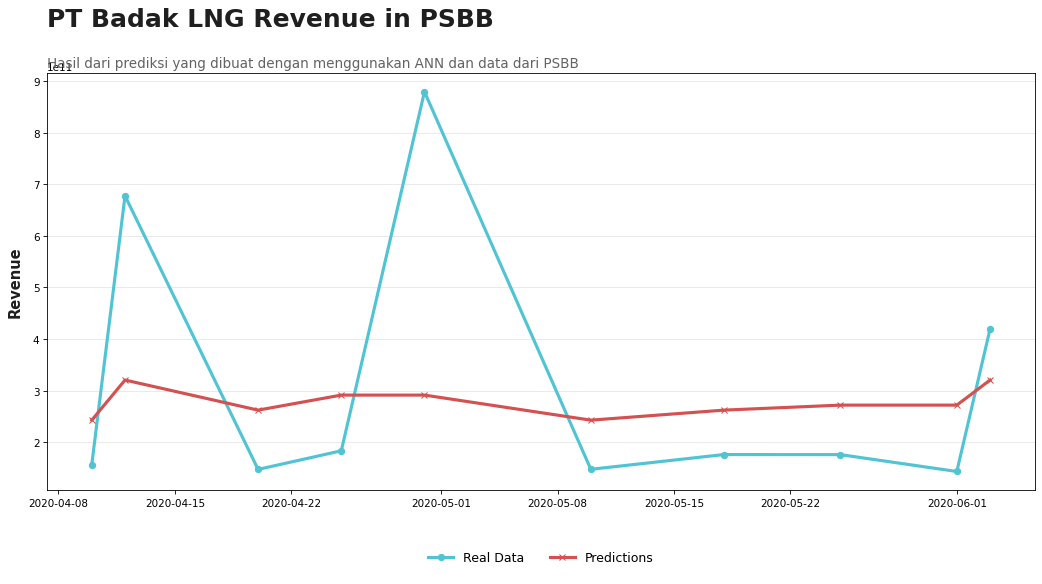

In [99]:
title_ann_standard = 'PT Badak LNG Revenue in PSBB'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PSBB'
plot_predictions(date_psbb_1,revenue_psbb_1_inv, revenue_psbb_1_pred_inv, title_ann_standard, subtitle_ann_standard)

## PSBB TRANSISI

In [100]:
df_psbb_trans = df[df['Kebijakan'] == 'PSBB  TRANSISI']
df_psbb_trans

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
10,PSBB TRANSISI,10.0,6.358678e+11,2020-06-13,1.420962,5,6,2020,0.833333,0.454545,0.0
11,PSBB TRANSISI,8.0,1.857537e+11,2020-06-21,-0.225786,6,6,2020,1.000000,0.454545,0.0
12,PSBB TRANSISI,11.0,1.973245e+11,2020-07-02,-0.183454,3,7,2020,0.500000,0.545455,0.0
13,PSBB TRANSISI,5.0,9.416419e+11,2020-07-07,2.539640,1,7,2020,0.166667,0.545455,0.0
14,PSBB TRANSISI,8.0,1.087409e+12,2020-07-15,3.072929,2,7,2020,0.333333,0.545455,0.0
15,PSBB TRANSISI,11.0,1.356611e+11,2020-07-26,-0.409050,6,7,2020,1.000000,0.545455,0.0
16,PSBB TRANSISI,13.0,1.476348e+11,2020-08-08,-0.365245,5,8,2020,0.833333,0.636364,0.0
17,PSBB TRANSISI,9.0,5.442950e+11,2020-08-17,1.085942,0,8,2020,0.000000,0.636364,0.0
18,PSBB TRANSISI,2.0,9.656752e+11,2020-08-19,2.627566,2,8,2020,0.333333,0.636364,0.0
19,PSBB TRANSISI,15.0,8.314508e+10,2020-09-03,-0.601181,3,9,2020,0.500000,0.727273,0.0


In [101]:
feature_psbb_trans_1 = df_psbb_trans['Periode (hari)']
revenue_psbb_trans_1 = df_psbb_trans['Revenue Scaled']

feature_psbb_trans_1.shape, revenue_psbb_trans_1.shape

((10,), (10,))

### Model

In [102]:
tf.random.set_seed(42)


# Build the model 
model_psbb_trans_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10), 
  tf.keras.layers.Dense(1) 
])

# Compile the model
model_psbb_trans_1.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_psbb_trans_1 = model_psbb_trans_1.fit(feature_psbb_trans_1, revenue_psbb_trans_1, batch_size=32, epochs=100, verbose=0, validation_split=0.3, shuffle=False) 

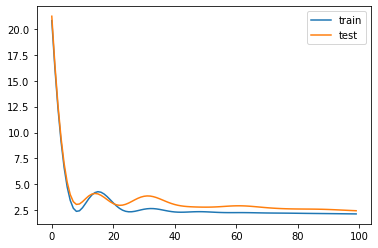

In [103]:
plt.plot(history_psbb_trans_1.history['loss'], label='train')
plt.plot(history_psbb_trans_1.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [104]:
revenUe_psbb_trans_pred_1 = model_psbb_trans_1.predict(feature_psbb_trans_1)
revenUe_psbb_trans_pred_1

array([[0.5777243 ],
       [0.5148073 ],
       [0.6091837 ],
       [0.4204304 ],
       [0.5148073 ],
       [0.6091837 ],
       [0.6721019 ],
       [0.54626566],
       [0.32605362],
       [0.73502004]], dtype=float32)

In [105]:
revenue_psbb_trans_1 = revenue_psbb_trans_1.to_numpy()
revenue_psbb_trans_1

array([ 1.42096156, -0.22578601, -0.18345437,  2.5396399 ,  3.0729288 ,
       -0.40905037, -0.36524472,  1.08594153,  2.62756614, -0.60118098])

In [106]:
revenue_psbb_trans_1_inv = revenue_scaler.inverse_transform(revenue_psbb_trans_1.reshape(-1,1))
revenue_psbb_trans_1_pred_inv = revenue_scaler.inverse_transform(revenUe_psbb_trans_pred_1)
revenue_psbb_trans_1_inv.shape, revenue_psbb_trans_1_pred_inv.shape 

((10, 1), (10, 1))

In [107]:
MSE_psbb_trans_1_Standard = mse(revenue_psbb_trans_1_inv, revenue_psbb_trans_1_pred_inv)
MAE_psbb_trans_1_Standard = mae(revenue_psbb_trans_1_inv, revenue_psbb_trans_1_pred_inv)
r2_psbb_trans_1 = r2_score(revenue_psbb_trans_1_inv, revenue_psbb_trans_1_pred_inv)

print(f'Mean Squared Error : {MSE_psbb_trans_1_Standard}')
print(f'Mean Absolute Error : {MAE_psbb_trans_1_Standard}')
print(f'Coefficient of Determination : {r2_psbb_trans_1}')

Mean Squared Error : 1.674251351999822e+23
Mean Absolute Error : 363174166528.0
Coefficient of Determination : -0.19774548360178423


### Visualization

In [108]:
revenue_psbb_trans_1_inv = revenue_psbb_trans_1_inv.squeeze()
revenue_psbb__trans_1_pred_inv = revenue_psbb_trans_1_pred_inv.squeeze()
date_psbb_trans_1 = df_psbb_trans['Tanggal']
date_psbb_trans_1 = date_psbb_trans_1.to_frame()

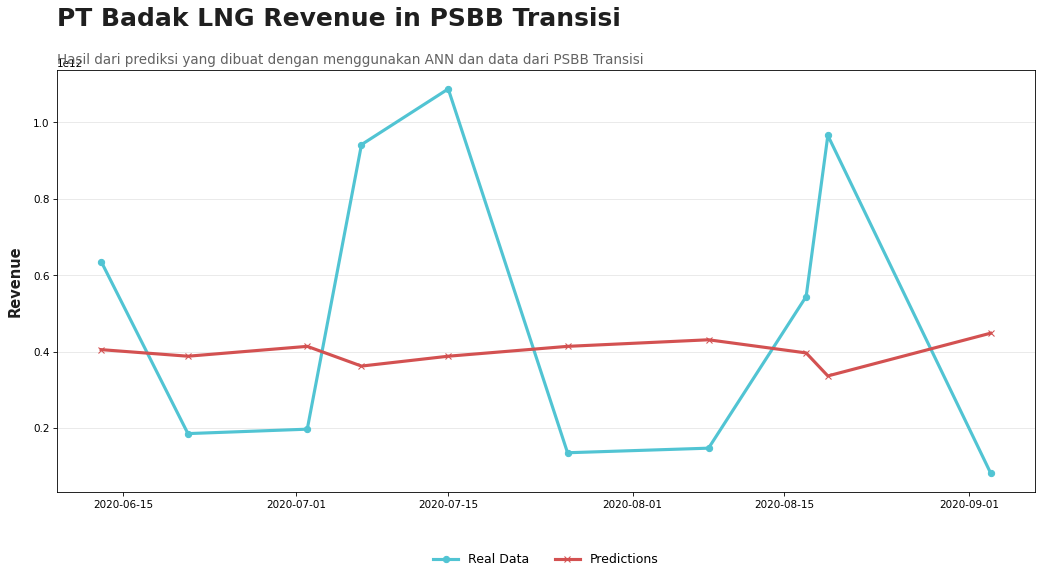

In [109]:
title_ann_standard = 'PT Badak LNG Revenue in PSBB Transisi'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PSBB Transisi'
plot_predictions(date_psbb_trans_1,revenue_psbb_trans_1_inv, revenue_psbb__trans_1_pred_inv, title_ann_standard, subtitle_ann_standard)

## PSBB KETAT

In [110]:
df_psbb_k = df[df['Kebijakan'] == 'PSBB KETAT']
df_psbb_k

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
20,PSBB KETAT,9.0,1.155736e+11,2020-09-12,-0.482541,5,9,2020,0.833333,0.727273,0.0
21,PSBB KETAT,6.0,8.324162e+10,2020-09-18,-0.600828,4,9,2020,0.666667,0.727273,0.0
22,PSBB KETAT,5.0,7.156432e+10,2020-09-23,-0.643549,2,9,2020,0.333333,0.727273,0.0
23,PSBB KETAT,2.0,6.962526e+11,2020-09-25,1.641880,4,9,2020,0.666667,0.727273,0.0
24,PSBB KETAT,3.0,3.823324e+11,2020-09-28,0.493399,0,9,2020,0.000000,0.727273,0.0
25,PSBB KETAT,5.0,9.670782e+10,2020-10-03,-0.551562,5,10,2020,0.833333,0.818182,0.0
26,PSBB KETAT,6.0,3.794796e+11,2020-10-09,0.482962,4,10,2020,0.666667,0.818182,0.0
27,PSBB KETAT,2.0,3.770154e+11,2020-10-11,0.473947,6,10,2020,1.000000,0.818182,0.0


In [111]:
feature_psbb_k_1 = df_psbb_k['Periode (hari)']
revenue_psbb_k_1 = df_psbb_k['Revenue Scaled']

feature_psbb_k_1.shape, revenue_psbb_k_1.shape

((8,), (8,))

### Model

In [112]:
tf.random.set_seed(42)


# Build the model 
model_psbb_k_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10), 
  tf.keras.layers.Dense(1) 
])

# Compile the model
model_psbb_k_1.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_psbb_k_1 = model_psbb_k_1.fit(feature_psbb_k_1, revenue_psbb_k_1, batch_size=32, epochs=100, verbose=0, validation_split=0.3, shuffle=False) 

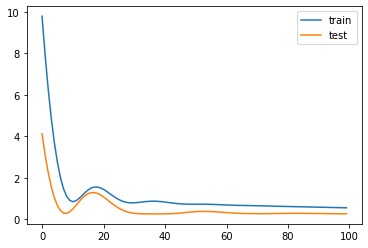

In [113]:
plt.plot(history_psbb_k_1.history['loss'], label='train')
plt.plot(history_psbb_k_1.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [114]:
revenUe_psbb_k_pred_1 = model_psbb_k_1.predict(feature_psbb_k_1)
revenUe_psbb_k_pred_1

array([[-0.5094278 ],
       [-0.20986319],
       [-0.11000819],
       [ 0.1895556 ],
       [ 0.08970103],
       [-0.11000819],
       [-0.20986313],
       [ 0.18955559]], dtype=float32)

In [115]:
revenue_psbb_k_1 = revenue_psbb_k_1.to_numpy()
revenue_psbb_k_1

array([-0.48254088, -0.60082778, -0.64354933,  1.64188024,  0.49339939,
       -0.55156153,  0.48296249,  0.47394721])

In [116]:
revenue_psbb_k_1_inv = revenue_scaler.inverse_transform(revenue_psbb_k_1.reshape(-1,1))
revenue_psbb_k_1_pred_inv = revenue_scaler.inverse_transform(revenUe_psbb_k_pred_1)
revenue_psbb_k_1_inv.shape, revenue_psbb_k_1_pred_inv.shape 

((8, 1), (8, 1))

In [117]:
MSE_psbb_k_1_Standard = mse(revenue_psbb_k_1_inv, revenue_psbb_k_1_pred_inv)
MAE_psbb_k_1_Standard = mae(revenue_psbb_k_1_inv, revenue_psbb_k_1_pred_inv)
r2_psbb_k_1 = r2_score(revenue_psbb_k_1_inv, revenue_psbb_k_1_pred_inv)

print(f'Mean Squared Error : {MSE_psbb_k_1_Standard}')
print(f'Mean Absolute Error : {MAE_psbb_k_1_Standard}')
print(f'Coefficient of Determination : {r2_psbb_k_1}')

Mean Squared Error : 3.237198671152981e+22
Mean Absolute Error : 144395681792.0
Coefficient of Determination : 0.25077591552287193


### Visualization

In [118]:
revenue_psbb_k_1_inv = revenue_psbb_k_1_inv.squeeze()
revenue_psbb__k_1_pred_inv = revenue_psbb_k_1_pred_inv.squeeze()
date_psbb_k_1 = df_psbb_k['Tanggal']
date_psbb_k_1 = date_psbb_k_1.to_frame()

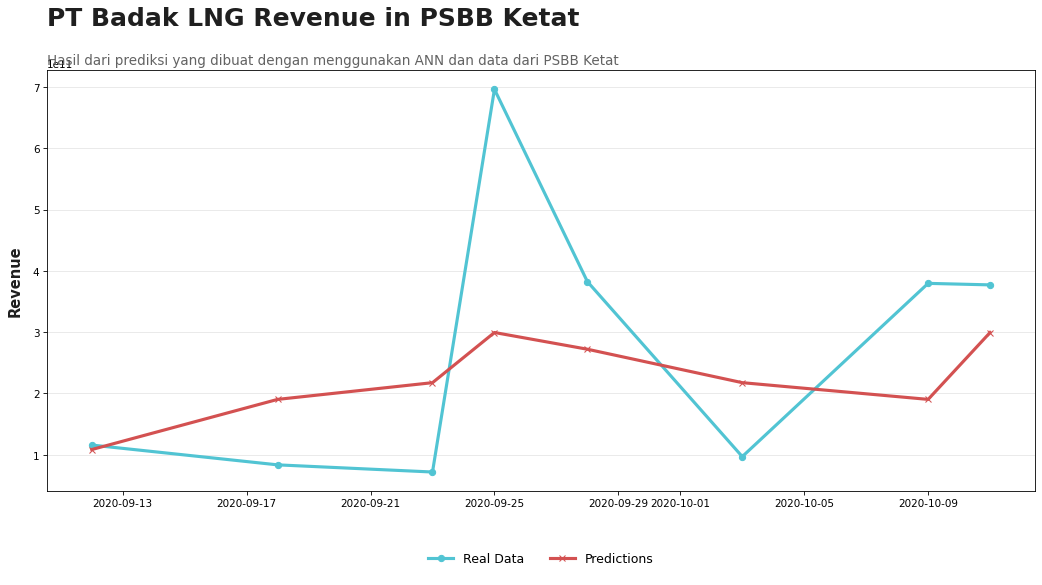

In [119]:
title_ann_standard = 'PT Badak LNG Revenue in PSBB Ketat'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PSBB Ketat'
plot_predictions(date_psbb_k_1,revenue_psbb_k_1_inv, revenue_psbb__k_1_pred_inv, title_ann_standard, subtitle_ann_standard)

## PSBB TRANSISI FASE 2

In [120]:
df_psbb_tf2 = df[df['Kebijakan'] == 'PSBB  TRANSISI FASE 2']
df_psbb_tf2

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
28,PSBB TRANSISI FASE 2,9.0,1.893239e+11,2020-10-20,-0.212725,1,10,2020,0.166667,0.818182,0.0
29,PSBB TRANSISI FASE 2,7.0,1.491147e+11,2020-10-27,-0.359831,1,10,2020,0.166667,0.818182,0.0
30,PSBB TRANSISI FASE 2,7.0,8.000991e+10,2020-11-03,-0.612651,1,11,2020,0.166667,0.909091,0.0
31,PSBB TRANSISI FASE 2,6.0,1.874729e+11,2020-11-09,-0.219496,0,11,2020,0.000000,0.909091,0.0
32,PSBB TRANSISI FASE 2,4.0,2.171203e+11,2020-11-13,-0.111031,4,11,2020,0.666667,0.909091,0.0
33,PSBB TRANSISI FASE 2,7.0,7.344057e+10,2020-11-20,-0.636685,4,11,2020,0.666667,0.909091,0.0
34,PSBB TRANSISI FASE 2,5.0,6.675399e+11,2020-11-25,1.536835,2,11,2020,0.333333,0.909091,0.0
35,PSBB TRANSISI FASE 2,10.0,9.461185e+10,2020-12-05,-0.559230,5,12,2020,0.833333,1.000000,0.0
36,PSBB TRANSISI FASE 2,15.0,4.613398e+10,2020-12-20,-0.736587,6,12,2020,1.000000,1.000000,0.0
37,PSBB TRANSISI FASE 2,5.0,1.520857e+11,2020-12-25,-0.348961,4,12,2020,0.666667,1.000000,0.0


In [121]:
feature_psbb_tf2_1 = df_psbb_tf2['Periode (hari)']
revenue_psbb_tf2_1 = df_psbb_tf2['Revenue Scaled']

feature_psbb_tf2_1.shape, revenue_psbb_tf2_1.shape

((10,), (10,))

### Model

In [122]:
tf.random.set_seed(42)


# Build the model 
model_psbb_tf2_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10), 
  tf.keras.layers.Dense(1) 
])

# Compile the model
model_psbb_tf2_1.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_psbb_tf2_1 = model_psbb_tf2_1.fit(feature_psbb_tf2_1, revenue_psbb_tf2_1, batch_size=32, epochs=100, verbose=0, validation_split=0.3, shuffle=False) 

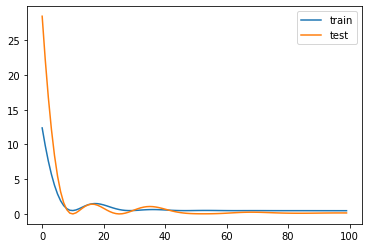

In [123]:
plt.plot(history_psbb_tf2_1.history['loss'], label='train')
plt.plot(history_psbb_tf2_1.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [124]:
revenUe_psbb_tf2_pred_1 = model_psbb_tf2_1.predict(feature_psbb_tf2_1)
revenUe_psbb_tf2_pred_1

array([[-0.173417  ],
       [-0.14505604],
       [-0.14505604],
       [-0.1308755 ],
       [-0.10251407],
       [-0.14505604],
       [-0.11669458],
       [-0.18759793],
       [-0.25850105],
       [-0.11669458]], dtype=float32)

In [125]:
revenue_psbb_tf2_1 = revenue_psbb_tf2_1.to_numpy()
revenue_psbb_tf2_1

array([-0.21272466, -0.3598305 , -0.61265103, -0.21949649, -0.11103115,
       -0.63668505,  1.53683462, -0.55922966, -0.73658654, -0.34896103])

In [126]:
revenue_psbb_tf2_1_inv = revenue_scaler.inverse_transform(revenue_psbb_tf2_1.reshape(-1,1))
revenue_psbb_tf2_1_pred_inv = revenue_scaler.inverse_transform(revenUe_psbb_tf2_pred_1)
revenue_psbb_tf2_1_inv.shape, revenue_psbb_tf2_1_pred_inv.shape 

((10, 1), (10, 1))

In [127]:
MSE_psbb_tf2_1_Standard = mse(revenue_psbb_tf2_1_inv, revenue_psbb_tf2_1_pred_inv)
MAE_psbb_tf2_1_Standard = mae(revenue_psbb_tf2_1_inv, revenue_psbb_tf2_1_pred_inv)
r2_psbb_tf2_1 = r2_score(revenue_psbb_tf2_1_inv, revenue_psbb_tf2_1_pred_inv)


print(f'Mean Squared Error : {MSE_psbb_tf2_1_Standard}')
print(f'Mean Absolute Error : {MAE_psbb_tf2_1_Standard}')
print(f'Coefficient of Determination : {r2_psbb_tf2_1}')

Mean Squared Error : 2.742477126186425e+22
Mean Absolute Error : 110590246912.0
Coefficient of Determination : 0.045065104269208955


### Visualization

In [128]:
revenue_psbb_tf2_1_inv = revenue_psbb_tf2_1_inv.squeeze()
revenue_psbb__tf2_1_pred_inv = revenue_psbb_tf2_1_pred_inv.squeeze()
date_psbb_tf2_1 = df_psbb_tf2['Tanggal']
date_psbb_tf2_1 = date_psbb_tf2_1.to_frame()

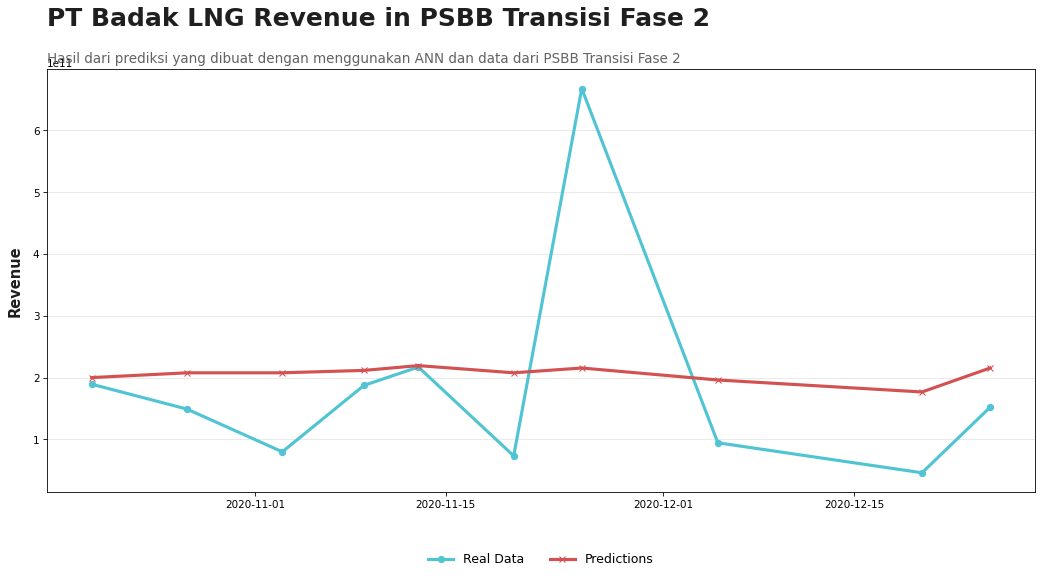

In [129]:
title_ann_standard = 'PT Badak LNG Revenue in PSBB Transisi Fase 2'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PSBB Transisi Fase 2'
plot_predictions(date_psbb_tf2_1,revenue_psbb_tf2_1_inv, revenue_psbb__tf2_1_pred_inv, title_ann_standard, subtitle_ann_standard)

## PPKM

In [130]:
df_ppkm = df[df['Kebijakan'] == 'PPKM']
df_ppkm

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
38,PPKM,7.0,7.015936e+10,2021-01-06,-0.648689,2,1,2021,0.333333,0.000000,1.0
39,PPKM,2.0,1.059919e+12,2021-01-08,2.972357,4,1,2021,0.666667,0.000000,1.0
40,PPKM,5.0,8.244473e+10,2021-01-13,-0.603743,2,1,2021,0.333333,0.000000,1.0
41,PPKM,8.0,6.036486e+10,2021-01-21,-0.684523,3,1,2021,0.500000,0.000000,1.0
42,PPKM,2.0,7.427046e+11,2021-01-23,1.811825,5,1,2021,0.833333,0.000000,1.0
43,PPKM,9.0,1.100094e+11,2021-02-01,-0.502898,0,2,2021,0.000000,0.090909,1.0
44,PPKM,2.0,6.009249e+11,2021-02-03,1.293123,2,2,2021,0.333333,0.090909,1.0
45,PPKM,5.0,5.233691e+10,2021-02-08,-0.713893,0,2,2021,0.000000,0.090909,1.0


In [131]:
feature_ppkm_1 = df_ppkm['Periode (hari)']
revenue_ppkm_1 = df_ppkm['Revenue Scaled']

feature_ppkm_1.shape, revenue_ppkm_1.shape

((8,), (8,))

### Model

In [132]:
tf.random.set_seed(42)


# Build the model 
model_ppkm_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10), 
  tf.keras.layers.Dense(1) 
])

# Compile the model
model_ppkm_1.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_ppkm_1 = model_ppkm_1.fit(feature_ppkm_1, revenue_ppkm_1, batch_size=32, epochs=100, verbose=0, validation_split=0.3, shuffle=False) 

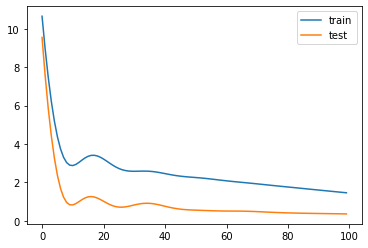

In [133]:
plt.plot(history_ppkm_1.history['loss'], label='train')
plt.plot(history_ppkm_1.history['val_loss'], label='test')
plt.legend();

### Evaluation|

In [134]:
revenUe_ppkm_pred_1 = model_ppkm_1.predict(feature_ppkm_1)
revenUe_ppkm_pred_1

array([[-0.29043588],
       [ 0.67920053],
       [ 0.09741885],
       [-0.48436287],
       [ 0.67920053],
       [-0.6782902 ],
       [ 0.6792004 ],
       [ 0.0974187 ]], dtype=float32)

In [135]:
revenue_ppkm_1 = revenue_ppkm_1.to_numpy()
revenue_ppkm_1

array([-0.6486894 ,  2.97235679, -0.60374322, -0.68452268,  1.81182541,
       -0.50289766,  1.29312264, -0.71389304])

In [136]:
revenue_ppkm_1_inv = revenue_scaler.inverse_transform(revenue_ppkm_1.reshape(-1,1))
revenue_ppkm_1_pred_inv = revenue_scaler.inverse_transform(revenUe_ppkm_pred_1)
revenue_ppkm_1_inv.shape, revenue_ppkm_1_pred_inv.shape 

((8, 1), (8, 1))

In [137]:
MSE_ppkm_1_Standard = mse(revenue_ppkm_1_inv, revenue_ppkm_1_pred_inv)
MAE_ppkm_1_Standard = mae(revenue_ppkm_1_inv, revenue_ppkm_1_pred_inv)
r2_ppkm_1 = r2_score(revenue_ppkm_1_inv, revenue_ppkm_1_pred_inv)

print(f'Mean Squared Error : {MSE_ppkm_1_Standard}')
print(f'Mean Absolute Error : {MAE_ppkm_1_Standard}')
print(f'Coefficient of Determination : {r2_ppkm_1}')

Mean Squared Error : 7.720873923412027e+22
Mean Absolute Error : 214772531200.0
Coefficient of Determination : 0.4390391912523399


### Visualization

In [138]:
revenue_ppkm_1_inv = revenue_ppkm_1_inv.squeeze()
revenue_ppkm_1_pred_inv = revenue_ppkm_1_pred_inv.squeeze()
date_ppkm_1 = df_ppkm['Tanggal']
date_ppkm_1 = date_ppkm_1.to_frame()

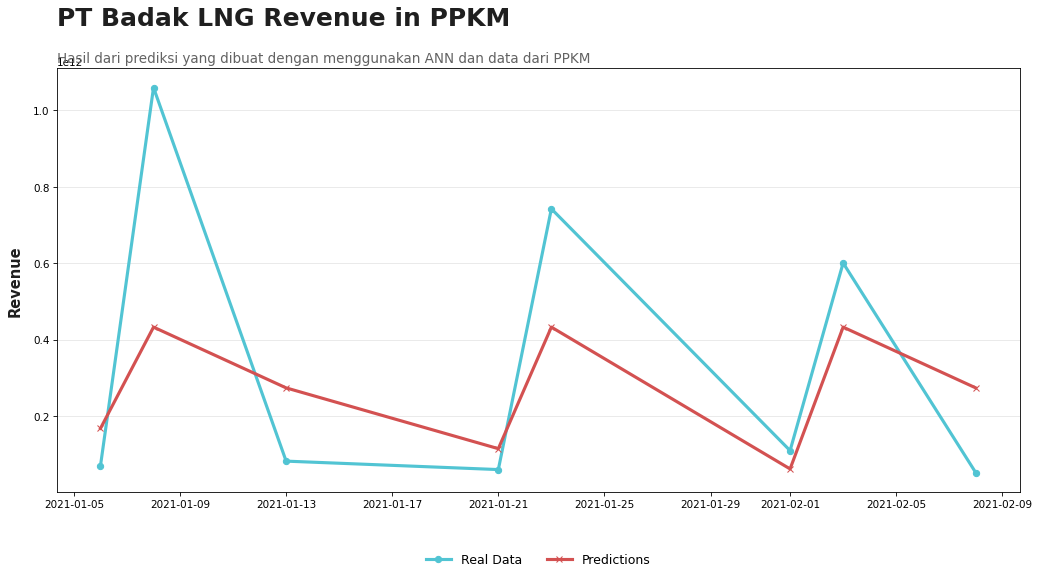

In [139]:
title_ann_standard = 'PT Badak LNG Revenue in PPKM'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PPKM'
plot_predictions(date_ppkm_1,revenue_ppkm_1_inv, revenue_ppkm_1_pred_inv, title_ann_standard, subtitle_ann_standard)

## PPKM  MIKRO

In [140]:
df_ppkm_mikro = df[df['Kebijakan'] == 'PPKM  MIKRO']
df_ppkm_mikro

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
46,PPKM MIKRO,6.0,7.329621e+10,2021-02-14,-0.637213,6,2,2021,1.000000,0.090909,1.0
47,PPKM MIKRO,4.0,1.576696e+11,2021-02-18,-0.328532,3,2,2021,0.500000,0.090909,1.0
48,PPKM MIKRO,3.0,5.125515e+11,2021-02-21,0.969807,6,2,2021,1.000000,0.090909,1.0
49,PPKM MIKRO,3.0,4.387788e+11,2021-02-24,0.699909,2,2,2021,0.333333,0.090909,1.0
50,PPKM MIKRO,5.0,6.246732e+10,2021-03-01,-0.676831,0,3,2021,0.000000,0.181818,1.0
51,PPKM MIKRO,3.0,4.248789e+11,2021-03-04,0.649056,3,3,2021,0.500000,0.181818,1.0
52,PPKM MIKRO,6.0,1.577392e+11,2021-03-10,-0.328278,2,3,2021,0.333333,0.181818,1.0
53,PPKM MIKRO,12.0,3.228827e+10,2021-03-22,-0.787241,0,3,2021,0.000000,0.181818,1.0
54,PPKM MIKRO,4.0,3.563277e+11,2021-03-26,0.398261,4,3,2021,0.666667,0.181818,1.0
55,PPKM MIKRO,5.0,4.487700e+11,2021-03-31,0.736462,2,3,2021,0.333333,0.181818,1.0


In [141]:
feature_ppkm_mikro_1 = df_ppkm_mikro['Periode (hari)']
revenue_ppkm_mikro_1 = df_ppkm_mikro['Revenue Scaled']

feature_ppkm_mikro_1.shape, revenue_ppkm_mikro_1.shape

((25,), (25,))

### Model

In [142]:
tf.random.set_seed(42)


# Build the model 
model_ppkm_mikro_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10), 
  tf.keras.layers.Dense(1) 
])

# Compile the model
model_ppkm_mikro_1.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_ppkm_mikro_1 = model_ppkm_mikro_1.fit(feature_ppkm_mikro_1, revenue_ppkm_mikro_1, batch_size=32, epochs=100, verbose=0, validation_split=0.3, shuffle=False)

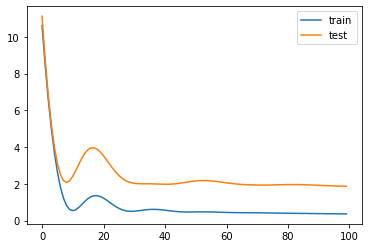

In [143]:
plt.plot(history_ppkm_mikro_1.history['loss'], label='train')
plt.plot(history_ppkm_mikro_1.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [144]:
revenUe_ppkm_mikro_pred_1 = model_ppkm_mikro_1.predict(feature_ppkm_mikro_1)
revenUe_ppkm_mikro_pred_1

array([[-0.16036215],
       [-0.0217947 ],
       [ 0.04748916],
       [ 0.04748916],
       [-0.09107822],
       [ 0.04748916],
       [-0.16036215],
       [-0.5760654 ],
       [-0.0217947 ],
       [-0.09107822],
       [-0.0217947 ],
       [ 0.11677295],
       [-0.4374971 ],
       [ 0.04748916],
       [-0.09107822],
       [-0.4374971 ],
       [-0.09107822],
       [-0.5067817 ],
       [-0.0217947 ],
       [-0.29892987],
       [-0.09107822],
       [-0.22964571],
       [-0.0217947 ],
       [-0.3682132 ],
       [-0.09107841]], dtype=float32)

In [145]:
revenue_ppkm_mikro_1 = revenue_ppkm_mikro_1.to_numpy()
revenue_ppkm_mikro_1

array([-0.63721318, -0.32853202,  0.96980745,  0.69990916, -0.67683083,
        0.64905643, -0.32827761, -0.78724121,  0.39826085,  0.73646218,
       -0.40222175,  1.38354256, -0.63813185,  1.00151706, -0.32984154,
       -0.77123464, -0.36481776, -0.60620641,  2.46703072, -0.64517891,
        1.1863331 , -0.43312055,  2.59774929, -0.60565411, -0.29334398])

In [146]:
revenue_ppkm_mikro_1_inv = revenue_scaler.inverse_transform(revenue_ppkm_mikro_1.reshape(-1,1))
revenue_ppkm_mikro_1_pred_inv = revenue_scaler.inverse_transform(revenUe_ppkm_mikro_pred_1)
revenue_ppkm_mikro_1_inv.shape, revenue_ppkm_mikro_1_pred_inv.shape 

((25, 1), (25, 1))

In [147]:
MSE_ppkm_mikro_1_Standard = mse(revenue_ppkm_mikro_1_inv, revenue_ppkm_mikro_1_pred_inv)
MAE_ppkm_mikro_1_Standard = mae(revenue_ppkm_mikro_1_inv, revenue_ppkm_mikro_1_pred_inv)
r2_ppkm_mikro_1 = r2_score(revenue_ppkm_mikro_1_inv, revenue_ppkm_mikro_1_pred_inv)

print(f'Mean Squared Error : {MSE_ppkm_mikro_1_Standard}')
print(f'Mean Absolute Error : {MAE_ppkm_mikro_1_Standard}')
print(f'Coefficient of Determination : {r2_ppkm_mikro_1}')

Mean Squared Error : 6.316619584040552e+22
Mean Absolute Error : 178160615424.0
Coefficient of Determination : 0.10139799388259774


### Visualization

In [148]:
revenue_ppkm_mikro_1_inv = revenue_ppkm_mikro_1_inv.squeeze()
revenue_ppkm_mikro_1_pred_inv = revenue_ppkm_mikro_1_pred_inv.squeeze()
date_ppkm_mikro_1 = df_ppkm_mikro['Tanggal']
date_ppkm_mikro_1 = date_ppkm_mikro_1.to_frame()

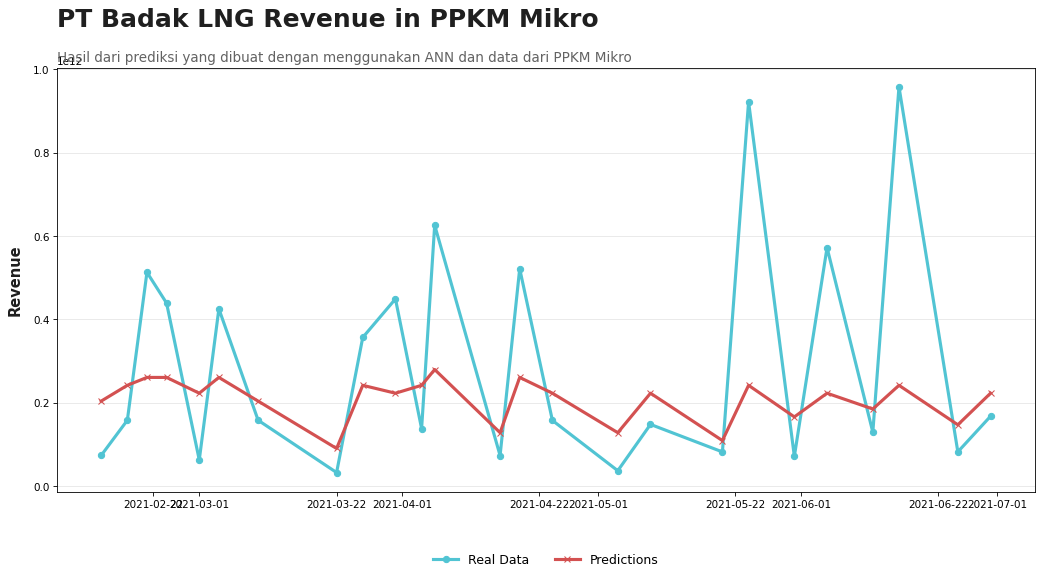

In [149]:
title_ann_standard = 'PT Badak LNG Revenue in PPKM Mikro'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PPKM Mikro'
plot_predictions(date_ppkm_mikro_1,revenue_ppkm_mikro_1_inv, revenue_ppkm_mikro_1_pred_inv, title_ann_standard, subtitle_ann_standard)

## PPKM DARURAT

In [150]:
df_ppkm_darurat = df[df['Kebijakan'] == 'PPKM DARURAT']
df_ppkm_darurat

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
71,PPKM DARURAT,3.0,3.146886e+11,2021-07-03,0.245924,5,7,2021,0.833333,0.545455,1.0
72,PPKM DARURAT,4.0,3.682184e+10,2021-07-07,-0.770655,2,7,2021,0.333333,0.545455,1.0
73,PPKM DARURAT,3.0,3.772735e+11,2021-07-10,0.474891,5,7,2021,0.833333,0.545455,1.0
74,PPKM DARURAT,3.0,4.029332e+10,2021-07-13,-0.757955,1,7,2021,0.166667,0.545455,1.0
75,PPKM DARURAT,1.0,4.859427e+10,2021-07-14,-0.727586,2,7,2021,0.333333,0.545455,1.0
76,PPKM DARURAT,3.0,3.779995e+10,2021-07-17,-0.767077,5,7,2021,0.833333,0.545455,1.0
77,PPKM DARURAT,2.0,4.150306e+10,2021-07-19,-0.753529,0,7,2021,0.000000,0.545455,1.0
78,PPKM DARURAT,1.0,1.318172e+11,2021-07-20,-0.423114,1,7,2021,0.166667,0.545455,1.0


In [151]:
feature_ppkm_darurat_1 = df_ppkm_darurat['Periode (hari)']
revenue_ppkm_darurat_1 = df_ppkm_darurat['Revenue Scaled']

feature_ppkm_darurat_1.shape, revenue_ppkm_darurat_1.shape

((8,), (8,))

### Model

In [152]:
tf.random.set_seed(42)


# Build the model 
model_ppkm_darurat_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10), 
  tf.keras.layers.Dense(1) 
])

# Compile the model
model_ppkm_darurat_1.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_ppkm_darurat_1 = model_ppkm_darurat_1.fit(feature_ppkm_darurat_1, revenue_ppkm_darurat_1, batch_size=32, epochs=100, verbose=0, validation_split=0.3, shuffle=False)

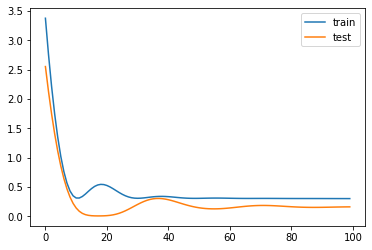

In [153]:
plt.plot(history_ppkm_darurat_1.history['loss'], label='train')
plt.plot(history_ppkm_darurat_1.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [154]:
revenUe_ppkm_darurat_pred_1 = model_ppkm_darurat_1.predict(feature_ppkm_darurat_1)
revenUe_ppkm_darurat_pred_1

array([[-0.277133  ],
       [-0.2768721 ],
       [-0.277133  ],
       [-0.277133  ],
       [-0.27765468],
       [-0.277133  ],
       [-0.27739382],
       [-0.27765465]], dtype=float32)

In [155]:
revenue_ppkm_darurat_1 = revenue_ppkm_darurat_1.to_numpy()
revenue_ppkm_darurat_1

array([ 0.24592371, -0.77065511,  0.47489131, -0.75795467, -0.72758553,
       -0.7670767 , -0.75352881, -0.42311354])

In [156]:
revenue_ppkm_darurat_1_inv = revenue_scaler.inverse_transform(revenue_ppkm_darurat_1.reshape(-1,1))
revenue_ppkm_darurat_1_pred_inv = revenue_scaler.inverse_transform(revenUe_ppkm_darurat_pred_1)
revenue_ppkm_darurat_1_inv.shape, revenue_ppkm_darurat_1_pred_inv.shape 

((8, 1), (8, 1))

In [157]:
MSE_ppkm_darurat_1_Standard = mse(revenue_ppkm_darurat_1_inv, revenue_ppkm_darurat_1_pred_inv)
MAE_ppkm_darurat_1_Standard = mae(revenue_ppkm_darurat_1_inv, revenue_ppkm_darurat_1_pred_inv)
r2_ppkm_darurat_1 = r2_score(revenue_ppkm_darurat_1_inv, revenue_ppkm_darurat_1_pred_inv)

print(f'Mean Squared Error : {MSE_ppkm_darurat_1_Standard}')
print(f'Mean Absolute Error : {MAE_ppkm_darurat_1_Standard}')
print(f'Coefficient of Determination : {r2_ppkm_darurat_1}')

Mean Squared Error : 1.8719918916306964e+22
Mean Absolute Error : 130215313408.0
Coefficient of Determination : -0.10989944132269458


### Visualization

In [158]:
revenue_ppkm_darurat_1_inv = revenue_ppkm_darurat_1_inv.squeeze()
revenue_ppkm_darurat_1_pred_inv = revenue_ppkm_darurat_1_pred_inv.squeeze()
date_ppkm_darurat_1 = df_ppkm_darurat['Tanggal']
date_ppkm_darurat_1 = date_ppkm_darurat_1.to_frame()

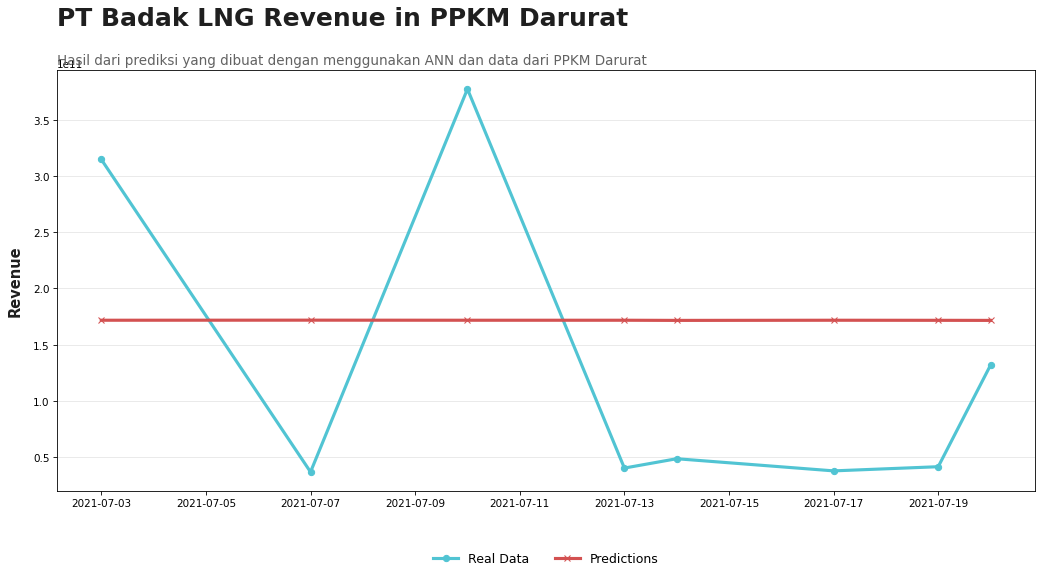

In [159]:
title_ann_standard = 'PT Badak LNG Revenue in PPKM Darurat'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PPKM Darurat'
plot_predictions(date_ppkm_darurat_1,revenue_ppkm_darurat_1_inv, revenue_ppkm_darurat_1_pred_inv, title_ann_standard, subtitle_ann_standard)

## PPKM LEVEL 3 & 4

In [160]:
df_ppkm_34 = df[df['Kebijakan'] == 'PPKM LEVEL 3 & 4']
df_ppkm_34

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
79,PPKM LEVEL 3 & 4,3.0,7.431663e+11,2021-07-23,1.813514,4,7,2021,0.666667,0.545455,1.0
80,PPKM LEVEL 3 & 4,4.0,4.606025e+10,2021-07-27,-0.736856,1,7,2021,0.166667,0.545455,1.0
81,PPKM LEVEL 3 & 4,6.0,3.508969e+10,2021-08-02,-0.776992,0,8,2021,0.000000,0.636364,1.0
82,PPKM LEVEL 3 & 4,5.0,3.969734e+10,2021-08-07,-0.760135,5,8,2021,0.833333,0.636364,1.0
83,PPKM LEVEL 3 & 4,2.0,1.024295e+11,2021-08-09,-0.530629,0,8,2021,0.000000,0.636364,1.0
84,PPKM LEVEL 3 & 4,6.0,4.888114e+10,2021-08-15,-0.726536,6,8,2021,1.000000,0.636364,1.0
85,PPKM LEVEL 3 & 4,4.0,4.675836e+10,2021-08-19,-0.734302,3,8,2021,0.500000,0.636364,1.0
86,PPKM LEVEL 3 & 4,3.0,7.862788e+10,2021-08-22,-0.617707,6,8,2021,1.000000,0.636364,1.0


In [161]:
feature_ppkm_34_1 = df_ppkm_34['Periode (hari)']
revenue_ppkm_34_1 = df_ppkm_34['Revenue Scaled']

feature_ppkm_34_1.shape, revenue_ppkm_34_1.shape

((8,), (8,))

### Model

In [162]:
tf.random.set_seed(42)


# Build the model 
model_ppkm_34_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10), 
  tf.keras.layers.Dense(1) 
])

# Compile the model
model_ppkm_34_1.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_ppkm_34_1 = model_ppkm_34_1.fit(feature_ppkm_34_1, revenue_ppkm_34_1, batch_size=32, epochs=100, verbose=0, validation_split=0.3, shuffle=False)

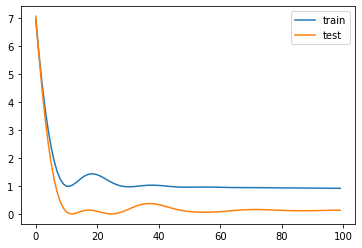

In [163]:
plt.plot(history_ppkm_34_1.history['loss'], label='train')
plt.plot(history_ppkm_34_1.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [164]:
revenUe_ppkm_34_pred_1 = model_ppkm_34_1.predict(feature_ppkm_34_1)
revenUe_ppkm_34_pred_1

array([[-0.18885261],
       [-0.28707832],
       [-0.4835295 ],
       [-0.38530388],
       [-0.09062714],
       [-0.4835295 ],
       [-0.2870782 ],
       [-0.18885256]], dtype=float32)

In [165]:
revenue_ppkm_34_1 = revenue_ppkm_34_1.to_numpy()
revenue_ppkm_34_1

array([ 1.81351442, -0.73685627, -0.77699219, -0.76013506, -0.53062882,
       -0.726536  , -0.73430223, -0.61770722])

In [166]:
revenue_ppkm_34_1_inv = revenue_scaler.inverse_transform(revenue_ppkm_34_1.reshape(-1,1))
revenue_ppkm_34_1_pred_inv = revenue_scaler.inverse_transform(revenUe_ppkm_34_pred_1)
revenue_ppkm_34_1_inv.shape, revenue_ppkm_34_1_pred_inv.shape 

((8, 1), (8, 1))

In [167]:
MSE_ppkm_34_1_Standard = mse(revenue_ppkm_34_1_inv, revenue_ppkm_34_1_pred_inv)
MAE_ppkm_34_1_Standard = mae(revenue_ppkm_34_1_inv, revenue_ppkm_34_1_pred_inv)
r2_ppkm_34_1 = r2_score(revenue_ppkm_34_1_inv, revenue_ppkm_34_1_pred_inv)


print(f'Mean Squared Error : {MSE_ppkm_34_1_Standard}')
print(f'Mean Absolute Error : {MAE_ppkm_34_1_Standard}')
print(f'Coefficient of Determination : {r2_ppkm_34_1}')

Mean Squared Error : 4.739523396010076e+22
Mean Absolute Error : 159884869632.0
Coefficient of Determination : 0.08816327655703149


### Visualization

In [168]:
revenue_ppkm_34_1_inv = revenue_ppkm_34_1_inv.squeeze()
revenue_ppkm_34_1_pred_inv = revenue_ppkm_34_1_pred_inv.squeeze()
date_ppkm_34_1 = df_ppkm_34['Tanggal']
date_ppkm_34_1 = date_ppkm_34_1.to_frame()

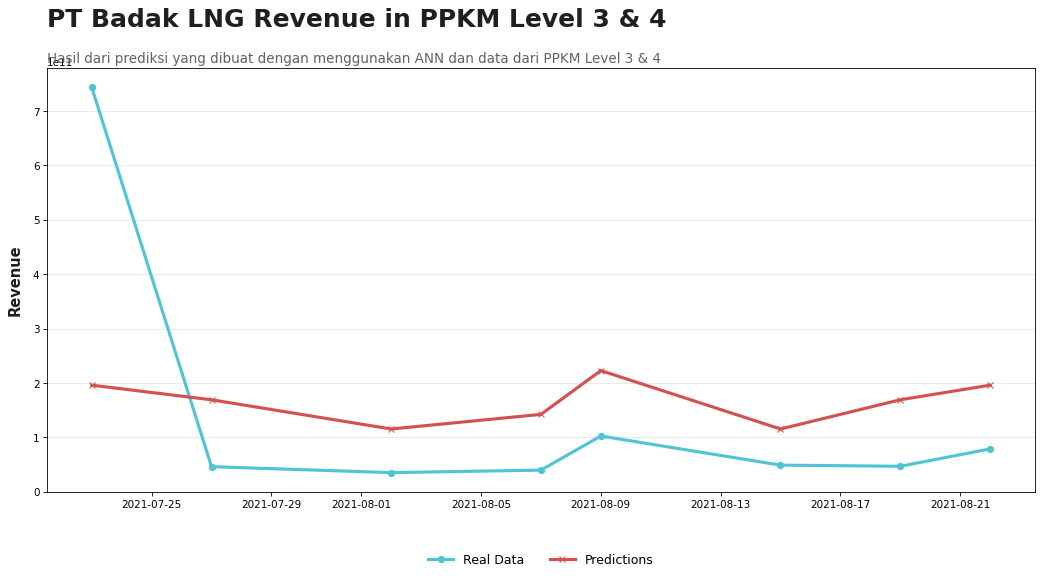

In [169]:
title_ann_standard = 'PT Badak LNG Revenue in PPKM Level 3 & 4'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PPKM Level 3 & 4'
plot_predictions(date_ppkm_34_1,revenue_ppkm_34_1_inv, revenue_ppkm_34_1_pred_inv, title_ann_standard, subtitle_ann_standard)

## PPKM LEVEL 2, 3, & 4

In [170]:
df_ppkm_234 = df[df['Kebijakan'] == 'PPKM LEVEL 2, 3, & 4']
df_ppkm_234

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
87,"PPKM LEVEL 2, 3, & 4",3.0,7.450172e+10,2021-08-25,-0.632803,2,8,2021,0.333333,0.636364,1.0
88,"PPKM LEVEL 2, 3, & 4",6.0,3.437665e+10,2021-08-31,-0.779601,1,8,2021,0.166667,0.636364,1.0
89,"PPKM LEVEL 2, 3, & 4",3.0,3.002385e+10,2021-09-03,-0.795526,4,9,2021,0.666667,0.727273,1.0
90,"PPKM LEVEL 2, 3, & 4",3.0,3.878350e+11,2021-09-06,0.513531,0,9,2021,0.000000,0.727273,1.0
91,"PPKM LEVEL 2, 3, & 4",5.0,3.872531e+10,2021-09-11,-0.763691,5,9,2021,0.833333,0.727273,1.0
92,"PPKM LEVEL 2, 3, & 4",4.0,7.181793e+10,2021-09-15,-0.642622,2,9,2021,0.333333,0.727273,1.0
93,"PPKM LEVEL 2, 3, & 4",4.0,4.041351e+10,2021-09-19,-0.757515,6,9,2021,1.000000,0.727273,1.0
94,"PPKM LEVEL 2, 3, & 4",5.0,3.464876e+10,2021-09-24,-0.778605,4,9,2021,0.666667,0.727273,1.0
95,"PPKM LEVEL 2, 3, & 4",6.0,2.898548e+10,2021-09-30,-0.799325,3,9,2021,0.500000,0.727273,1.0
96,"PPKM LEVEL 2, 3, & 4",7.0,2.594012e+10,2021-10-07,-0.810466,3,10,2021,0.500000,0.818182,1.0


In [171]:
feature_ppkm_234_1 = df_ppkm_234['Periode (hari)']
revenue_ppkm_234_1 = df_ppkm_234['Revenue Scaled']

feature_ppkm_234_1.shape, revenue_ppkm_234_1.shape

((10,), (10,))

### Model

In [172]:
tf.random.set_seed(42)


# Build the model 
model_ppkm_234_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10), 
  tf.keras.layers.Dense(1) 
])

# Compile the model
model_ppkm_234_1.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_ppkm_234_1 = model_ppkm_234_1.fit(feature_ppkm_234_1, revenue_ppkm_234_1, batch_size=32, epochs=100, verbose=0, validation_split=0.3, shuffle=False)

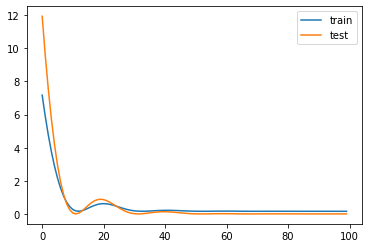

In [173]:
plt.plot(history_ppkm_234_1.history['loss'], label='train')
plt.plot(history_ppkm_234_1.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [174]:
revenUe_ppkm_234_pred_1 = model_ppkm_234_1.predict(feature_ppkm_234_1)
revenUe_ppkm_234_pred_1

array([[-0.46931118],
       [-0.7875584 ],
       [-0.46931118],
       [-0.46931118],
       [-0.6814759 ],
       [-0.57539356],
       [-0.57539356],
       [-0.6814759 ],
       [-0.7875584 ],
       [-0.893641  ]], dtype=float32)

In [175]:
revenue_ppkm_234_1 = revenue_ppkm_234_1.to_numpy()
revenue_ppkm_234_1

array([-0.63280282, -0.77960087, -0.79552564,  0.51353073, -0.76369122,
       -0.64262151, -0.75751493, -0.77860535, -0.79932453, -0.810466  ])

In [176]:
revenue_ppkm_234_1_inv = revenue_scaler.inverse_transform(revenue_ppkm_234_1.reshape(-1,1))
revenue_ppkm_234_1_pred_inv = revenue_scaler.inverse_transform(revenUe_ppkm_234_pred_1)
revenue_ppkm_234_1_inv.shape, revenue_ppkm_234_1_pred_inv.shape 

((10, 1), (10, 1))

In [177]:
MSE_ppkm_234_1_Standard = mse(revenue_ppkm_234_1_inv, revenue_ppkm_234_1_pred_inv)
MAE_ppkm_234_1_Standard = mae(revenue_ppkm_234_1_inv, revenue_ppkm_234_1_pred_inv)
r2_ppkm_234_1 = r2_score(revenue_ppkm_234_1_inv, revenue_ppkm_234_1_pred_inv)

print(f'Mean Squared Error : {MSE_ppkm_234_1_Standard}')
print(f'Mean Absolute Error : {MAE_ppkm_234_1_Standard}')
print(f'Coefficient of Determination : {r2_ppkm_234_1}')

Mean Squared Error : 8.667537770844709e+21
Mean Absolute Error : 54780219392.0
Coefficient of Determination : 0.21335722454873074


### Visualization

In [178]:
revenue_ppkm_234_1_inv = revenue_ppkm_234_1_inv.squeeze()
revenue_ppkm_234_1_pred_inv = revenue_ppkm_234_1_pred_inv.squeeze()
date_ppkm_234_1 = df_ppkm_234['Tanggal']
date_ppkm_234_1 = date_ppkm_234_1.to_frame()

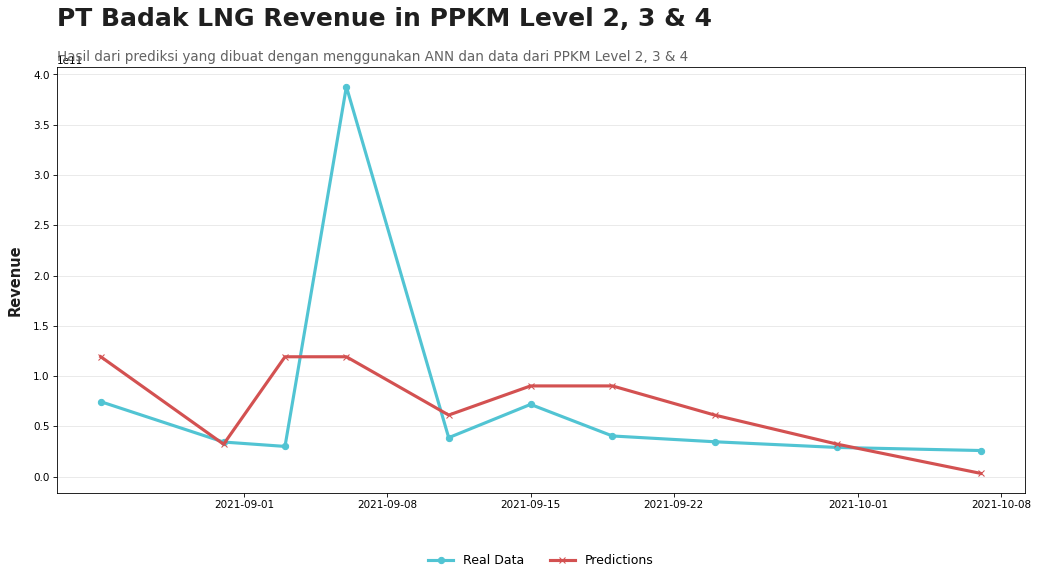

In [179]:
title_ann_standard = 'PT Badak LNG Revenue in PPKM Level 2, 3 & 4'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PPKM Level 2, 3 & 4'
plot_predictions(date_ppkm_234_1,revenue_ppkm_234_1_inv, revenue_ppkm_234_1_pred_inv, title_ann_standard, subtitle_ann_standard)

## PPKM  LEVEL 1, 2, & 3

In [180]:
df_ppkm_123 = df[df['Kebijakan'] == 'PPKM  LEVEL 1, 2, & 3']
df_ppkm_123

,Kebijakan,Periode (hari),Revenue,Tanggal,Revenue Scaled,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
97,"PPKM LEVEL 1, 2, & 3",12.0,1.732555e+11,2021-10-19,-0.271511,1,10,2021,0.166667,0.818182,1.0
98,"PPKM LEVEL 1, 2, & 3",8.0,3.539399e+10,2021-10-27,-0.775879,2,10,2021,0.333333,0.818182,1.0
99,"PPKM LEVEL 1, 2, & 3",9.0,3.257680e+10,2021-11-05,-0.786186,4,11,2021,0.666667,0.909091,1.0
100,"PPKM LEVEL 1, 2, & 3",3.0,6.923571e+11,2021-11-08,1.627628,0,11,2021,0.000000,0.909091,1.0
101,"PPKM LEVEL 1, 2, & 3",7.0,3.670740e+10,2021-11-15,-0.771074,0,11,2021,0.000000,0.909091,1.0
102,"PPKM LEVEL 1, 2, & 3",8.0,3.308818e+10,2021-11-23,-0.784315,1,11,2021,0.166667,0.909091,1.0
103,"PPKM LEVEL 1, 2, & 3",2.0,9.634531e+10,2021-11-25,-0.552888,3,11,2021,0.500000,0.909091,1.0
104,"PPKM LEVEL 1, 2, & 3",9.0,3.496118e+10,2021-12-04,-0.777462,5,12,2021,0.833333,1.000000,1.0
105,"PPKM LEVEL 1, 2, & 3",8.0,3.284880e+10,2021-12-12,-0.785191,6,12,2021,1.000000,1.000000,1.0
106,"PPKM LEVEL 1, 2, & 3",7.0,1.610741e+11,2021-12-19,-0.316077,6,12,2021,1.000000,1.000000,1.0


In [181]:
feature_ppkm_123_1 = df_ppkm_123['Periode (hari)']
revenue_ppkm_123_1 = df_ppkm_123['Revenue Scaled']

feature_ppkm_123_1.shape, revenue_ppkm_123_1.shape

((10,), (10,))

### Model

In [182]:
tf.random.set_seed(42)


# Build the model 
model_ppkm_123_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10), 
  tf.keras.layers.Dense(1) 
])

# Compile the model
model_ppkm_123_1.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_ppkm_123_1 = model_ppkm_123_1.fit(feature_ppkm_123_1, revenue_ppkm_123_1, batch_size=32, epochs=100, verbose=0, validation_split=0.3, shuffle=False)

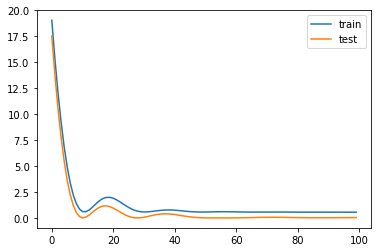

In [183]:
plt.plot(history_ppkm_123_1.history['loss'], label='train')
plt.plot(history_ppkm_123_1.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [184]:
revenUe_ppkm_123_pred_1 = model_ppkm_123_1.predict(feature_ppkm_123_1)
revenUe_ppkm_123_pred_1

array([[-0.66741043],
       [-0.45578277],
       [-0.5086891 ],
       [-0.19124839],
       [-0.40287554],
       [-0.45578277],
       [-0.13834165],
       [-0.5086891 ],
       [-0.45578277],
       [-0.40287554]], dtype=float32)

In [185]:
revenue_ppkm_123_1 = revenue_ppkm_123_1.to_numpy()
revenue_ppkm_123_1

array([-0.27151108, -0.77587893, -0.78618562,  1.62762838, -0.7710738 ,
       -0.78431474, -0.55288778, -0.77746235, -0.78519053, -0.31607668])

In [186]:
revenue_ppkm_123_1_inv = revenue_scaler.inverse_transform(revenue_ppkm_123_1.reshape(-1,1))
revenue_ppkm_123_1_pred_inv = revenue_scaler.inverse_transform(revenUe_ppkm_123_pred_1)
revenue_ppkm_123_1_inv.shape, revenue_ppkm_123_1_pred_inv.shape 

((10, 1), (10, 1))

In [187]:
MSE_ppkm_123_1_Standard = mse(revenue_ppkm_123_1_inv, revenue_ppkm_123_1_pred_inv)
MAE_ppkm_123_1_Standard = mae(revenue_ppkm_123_1_inv, revenue_ppkm_123_1_pred_inv)
r2_ppkm_123_1 = r2_score(revenue_ppkm_123_1_inv, revenue_ppkm_123_1_pred_inv)

print(f'Mean Squared Error : {MSE_ppkm_123_1_Standard}')
print(f'Mean Absolute Error : {MAE_ppkm_123_1_Standard}')
print(f'Coefficient of Determination : {r2_ppkm_123_1}')

Mean Squared Error : 3.173881888451835e+22
Mean Absolute Error : 125969940480.0
Coefficient of Determination : 0.15394871212234051


### Visualization

In [188]:
revenue_ppkm_123_1_inv = revenue_ppkm_123_1_inv.squeeze()
revenue_ppkm_123_1_pred_inv = revenue_ppkm_123_1_pred_inv.squeeze()
date_ppkm_123_1 = df_ppkm_123['Tanggal']
date_ppkm_123_1 = date_ppkm_123_1.to_frame()

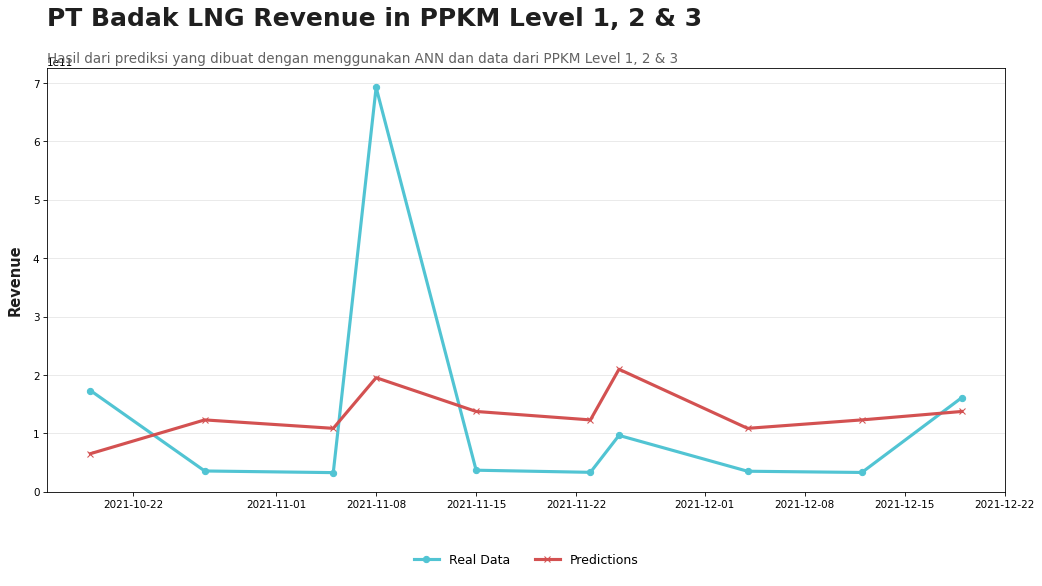

In [189]:
title_ann_standard = 'PT Badak LNG Revenue in PPKM Level 1, 2 & 3'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PPKM Level 1, 2 & 3'
plot_predictions(date_ppkm_123_1,revenue_ppkm_123_1_inv, revenue_ppkm_123_1_pred_inv, title_ann_standard, subtitle_ann_standard)

# Dataset Long

In [190]:
df_long = pd.read_excel('/content/drive/MyDrive/skripsi ghanes/dataset long.xlsx', sheet_name='long')
df_long.head()

,Kebijakan,Tanggal,Revenue
0,PSBB,2020-04-10,1.561507e+11
1,PSBB,2020-04-11,0.000000e+00
2,PSBB,2020-04-12,6.774117e+11
3,PSBB,2020-04-13,0.000000e+00
4,PSBB,2020-04-14,0.000000e+00


## Data Preparation

In [191]:
df_long['hari'] = df_long['Tanggal'].dt.day_of_week
df_long['bulan'] = df_long['Tanggal'].dt.month
df_long['tahun'] = df_long['Tanggal'].dt.year

df_long.head()

,Kebijakan,Tanggal,Revenue,hari,bulan,tahun
0,PSBB,2020-04-10,1.561507e+11,4,4,2020
1,PSBB,2020-04-11,0.000000e+00,5,4,2020
2,PSBB,2020-04-12,6.774117e+11,6,4,2020
3,PSBB,2020-04-13,0.000000e+00,0,4,2020
4,PSBB,2020-04-14,0.000000e+00,1,4,2020


In [192]:
features_date_day_scaler_1 = MinMaxScaler()
features_date_month_scaler_1 = MinMaxScaler()
features_date_year_scaler_1 = MinMaxScaler()


day_scaled_1 = features_date_day_scaler_1.fit_transform(df_long['hari'].values.reshape(-1,1))
df_long['Day Scaled'] = day_scaled_1

month_scaled_1 = features_date_month_scaler_1.fit_transform(df_long['bulan'].values.reshape(-1,1))
df_long['Month Scaled'] = month_scaled_1

year_scaled_1= features_date_year_scaler_1.fit_transform(df_long['tahun'].values.reshape(-1,1))
df_long['Year Scaled'] = year_scaled_1


df_long.head()

,Kebijakan,Tanggal,Revenue,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled
0,PSBB,2020-04-10,1.561507e+11,4,4,2020,0.666667,0.0,0.0
1,PSBB,2020-04-11,0.000000e+00,5,4,2020,0.833333,0.0,0.0
2,PSBB,2020-04-12,6.774117e+11,6,4,2020,1.000000,0.0,0.0
3,PSBB,2020-04-13,0.000000e+00,0,4,2020,0.000000,0.0,0.0
4,PSBB,2020-04-14,0.000000e+00,1,4,2020,0.166667,0.0,0.0


In [193]:
revenue_scaler_1 = StandardScaler()

revenue_scaled_1 = revenue_scaler_1.fit_transform(df_long['Revenue'].values.reshape(-1,1))
df_long['Revenue Scaled'] = revenue_scaled_1
df_long.head()

,Kebijakan,Tanggal,Revenue,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled,Revenue Scaled
0,PSBB,2020-04-10,1.561507e+11,4,4,2020,0.666667,0.0,0.0,0.518467
1,PSBB,2020-04-11,0.000000e+00,5,4,2020,0.833333,0.0,0.0,-0.328324
2,PSBB,2020-04-12,6.774117e+11,6,4,2020,1.000000,0.0,0.0,3.345218
3,PSBB,2020-04-13,0.000000e+00,0,4,2020,0.000000,0.0,0.0,-0.328324
4,PSBB,2020-04-14,0.000000e+00,1,4,2020,0.166667,0.0,0.0,-0.328324


## Visualization

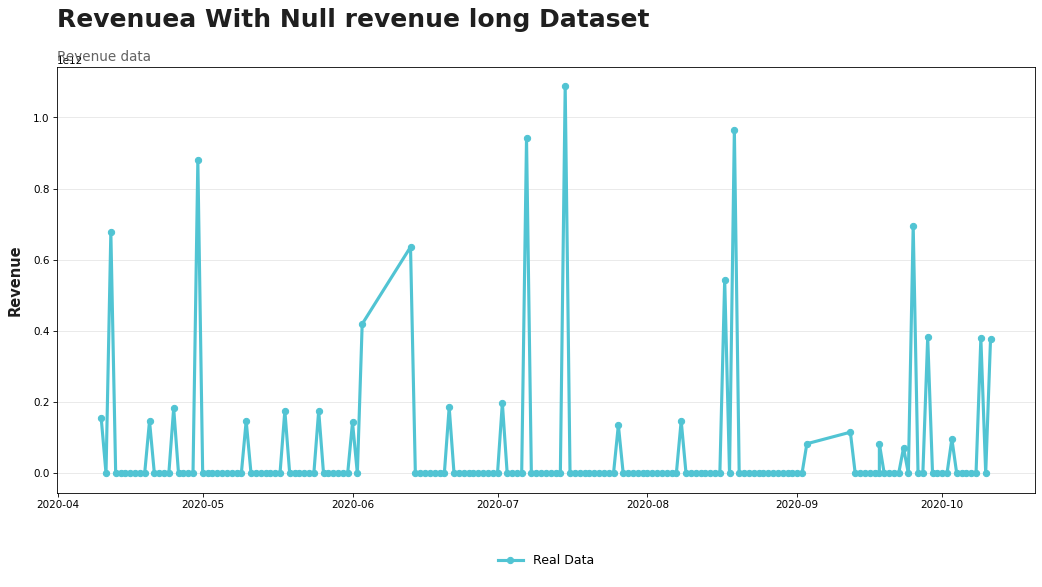

In [194]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=75)
line_real_data = ax.plot(df_long['Tanggal'], df_long['Revenue'], alpha=1, marker='o', color=colors_blue[3], linewidth=3, label='Real Data')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, borderpad=1, frameon=False, fontsize=12)
ax.grid(axis='y', alpha=0.3)
ax.set_axisbelow(True)
# ax.set_xlabel("Countries", fontsize=14, labelpad=10, fontweight='bold', color=colors_dark[0])
ax.set_ylabel("Revenue", fontsize=14, labelpad=10, fontweight='bold', color=colors_dark[0])

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
plt.text(s='Revenuea With Null revenue long Dataset', ha='left', x=xmin, y=ymax*1.1, fontsize=24, fontweight='bold', color=colors_dark[0])
plt.title('Revenue data', loc='left', fontsize=13, color=colors_dark[2])  
plt.tight_layout()
plt.show()

## Testing with PSBB

In [195]:
df_psbb_3 = df_long[df_long['Kebijakan'] == 'PSBB']
df_psbb_3

,Kebijakan,Tanggal,Revenue,hari,bulan,tahun,Day Scaled,Month Scaled,Year Scaled,Revenue Scaled
0,PSBB,2020-04-10,1.561507e+11,4,4,2020,0.666667,0.000000,0.0,0.518467
1,PSBB,2020-04-11,0.000000e+00,5,4,2020,0.833333,0.000000,0.0,-0.328324
2,PSBB,2020-04-12,6.774117e+11,6,4,2020,1.000000,0.000000,0.0,3.345218
3,PSBB,2020-04-13,0.000000e+00,0,4,2020,0.000000,0.000000,0.0,-0.328324
4,PSBB,2020-04-14,0.000000e+00,1,4,2020,0.166667,0.000000,0.0,-0.328324
5,PSBB,2020-04-15,0.000000e+00,2,4,2020,0.333333,0.000000,0.0,-0.328324
6,PSBB,2020-04-16,0.000000e+00,3,4,2020,0.500000,0.000000,0.0,-0.328324
7,PSBB,2020-04-17,0.000000e+00,4,4,2020,0.666667,0.000000,0.0,-0.328324
8,PSBB,2020-04-18,0.000000e+00,5,4,2020,0.833333,0.000000,0.0,-0.328324
9,PSBB,2020-04-19,0.000000e+00,6,4,2020,1.000000,0.000000,0.0,-0.328324


In [196]:
feature_psbb_3 = df_psbb_3[column_date_features]
revenue_psbb_3 = df_psbb_3['Revenue Scaled']

feature_psbb_3.shape, revenue_psbb_3.shape

((55, 3), (55,))

### Modelling

In [197]:
tf.random.set_seed(42)


# Build the model 
model_psbb_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(224, activation='tanh'),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(480, activation='relu'),
  tf.keras.layers.Dense(272, activation='relu'),
  tf.keras.layers.Dense(208, activation='relu'),
  tf.keras.layers.Dense(112, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')  
])

# Compile the model
model_psbb_3.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          metrics=['mse', 'mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history_model_psbb_3 = model_psbb_3.fit(feature_psbb_3, revenue_psbb_3, batch_size=32, epochs=100, verbose=0, validation_split=0.25, shuffle=False) 

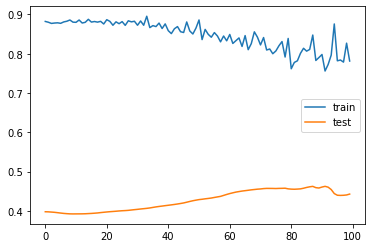

In [198]:
plt.plot(history_model_psbb_3.history['loss'], label='train')
plt.plot(history_model_psbb_3.history['val_loss'], label='test')
plt.legend();

### Evaluation

In [199]:
revenUe_psbb_pred_3 = model_psbb_3.predict(feature_psbb_3)
revenUe_psbb_pred_3

array([[ 2.7975389e-01],
       [ 3.8034317e-01],
       [ 4.7096825e-01],
       [-4.0658808e-04],
       [-8.6311430e-02],
       [ 4.1677948e-02],
       [ 1.6770236e-01],
       [ 2.7975389e-01],
       [ 3.8034317e-01],
       [ 4.7096825e-01],
       [-4.0658808e-04],
       [-8.6311430e-02],
       [ 4.1677948e-02],
       [ 1.6770236e-01],
       [ 2.7975389e-01],
       [ 3.8034317e-01],
       [ 4.7096825e-01],
       [-4.0658808e-04],
       [-8.6311430e-02],
       [ 4.1677948e-02],
       [ 1.6770236e-01],
       [-3.4906384e-01],
       [-2.5632942e-01],
       [-1.3774416e-01],
       [ 1.4496007e-02],
       [-2.1449307e-01],
       [-3.5925683e-01],
       [-3.9209673e-01],
       [-3.4906384e-01],
       [-2.5632942e-01],
       [-1.3774422e-01],
       [ 1.4496013e-02],
       [-2.1449307e-01],
       [-3.5925683e-01],
       [-3.9209673e-01],
       [-3.4906384e-01],
       [-2.5632942e-01],
       [-1.3774416e-01],
       [ 1.4496007e-02],
       [-2.1449307e-01],


In [200]:
revenue_psbb_3 = revenue_psbb_3.to_numpy()
revenue_psbb_3

array([ 0.51846691, -0.32832418,  3.34521819, -0.32832418, -0.32832418,
       -0.32832418, -0.32832418, -0.32832418, -0.32832418, -0.32832418,
        0.47032086, -0.32832418, -0.32832418, -0.32832418, -0.32832418,
        0.66569373, -0.32832418, -0.32832418, -0.32832418, -0.32832418,
        4.43900426, -0.32832418, -0.32832418, -0.32832418, -0.32832418,
       -0.32832418, -0.32832418, -0.32832418, -0.32832418, -0.32832418,
        0.47130915, -0.32832418, -0.32832418, -0.32832418, -0.32832418,
       -0.32832418, -0.32832418, -0.32832418,  0.62632639, -0.32832418,
       -0.32832418, -0.32832418, -0.32832418, -0.32832418, -0.32832418,
        0.62550683, -0.32832418, -0.32832418, -0.32832418, -0.32832418,
       -0.32832418, -0.32832418,  0.44826202, -0.32832418,  1.94666584])

In [201]:
revenue_psbb_3_inv = revenue_scaler_1.inverse_transform(revenue_psbb_3.reshape(-1,1))
revenue_psbb_3_pred_inv = revenue_scaler_1.inverse_transform(revenUe_psbb_pred_3)
revenue_psbb_3_inv.shape, revenue_psbb_3_pred_inv.shape 

((55, 1), (55, 1))

In [202]:
MSE_psbb_3_Standard = mse(revenue_psbb_3_inv, revenue_psbb_3_pred_inv)
MAE_psbb_3_Standard = mae(revenue_psbb_3_inv, revenue_psbb_3_pred_inv)
r2_psbb_3 = r2_score(revenue_psbb_3_inv, revenue_psbb_3_pred_inv)
mape_psbb_3 = mean_absolute_percentage_error(revenue_psbb_3_inv, revenue_psbb_3_pred_inv)

print(f'Mean Squared Error : {MSE_psbb_3_Standard}')
print(f'Mean Absolute Error : {MAE_psbb_3_Standard}')
print(f'Coefficient of Determination : {r2_psbb_3}')
print(f'Mean Absolute Percentage Error : {mape_psbb_3}')


Mean Squared Error : 2.3801348390267604e+22
Mean Absolute Error : 78332116992.0
Coefficient of Determination : 0.07566255825779333
Mean Absolute Percentage Error : 4663476129361250.0


### Visualization

In [203]:
revenue_psbb_3_inv = revenue_psbb_3_inv.squeeze()
revenue_psbb_3_pred_inv = revenue_psbb_3_pred_inv.squeeze()
date_psbb_3 = df_psbb_3['Tanggal']
date_psbb_3 = date_psbb_3.to_frame()

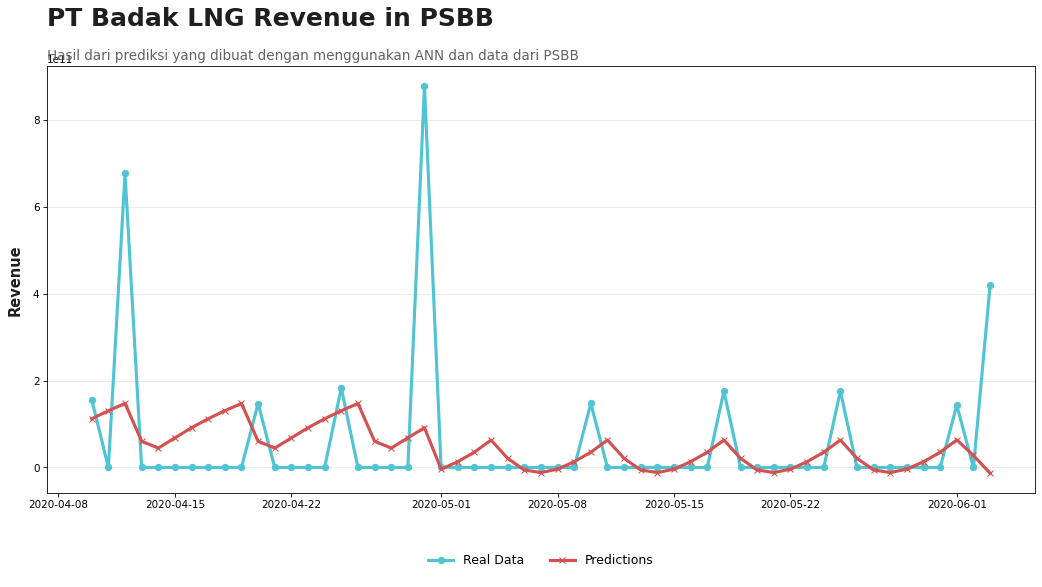

In [204]:
title_ann_standard = 'PT Badak LNG Revenue in PSBB'
subtitle_ann_standard = 'Hasil dari prediksi yang dibuat dengan menggunakan ANN dan data dari PSBB'
plot_predictions(date_psbb_3,revenue_psbb_3_inv, revenue_psbb_3_pred_inv, title_ann_standard, subtitle_ann_standard)